# PA004 - Health Insurance Cross sell

## 0.0 Imports

In [2]:
# Data manipulation
import pandas         as pd
import numpy          as np

# Data visualization
from matplotlib            import pyplot    as plt
import seaborn                              as sns

# Stats
from scipy                 import stats     as ss

# Encoding
from imblearn.combine        import SMOTETomek
from sklearn.preprocessing   import RobustScaler, MinMaxScaler, OneHotEncoder

# Feature selection
from sklearn.feature_selection import RFECV
from yellowbrick.features      import Rank1D

# Modeling
import xgboost                                      as xgb
import ydata_profiling
from pandas_profiling        import ProfileReport
from sklearn                 import preprocessing   as pp
from sklearn                 import linear_model    as lm
from sklearn                 import model_selection as ms
from sklearn                 import ensemble        as en
from sklearn                 import neighbors       as nh
from sklearn                 import metrics         as m
from boruta                  import BorutaPy
from lightgbm                import LGBMClassifier
from skopt                   import forest_minimize
from skopt.plots             import plot_convergence
from sklearn.ensemble        import RandomForestRegressor
from sklearn.ensemble        import RandomForestClassifier
from sklearn.ensemble        import ExtraTreesClassifier
from sklearn.linear_model    import LogisticRegression
from sklearn.naive_bayes     import GaussianNB
from sklearn.neighbors       import KNeighborsClassifier
from sklearn                 import svm
from sklearn                 import base

# Model selection
from sklearn.model_selection import KFold
from sklearn.model_selection import StratifiedKFold

# Metrics
import scikitplot     as skplt
from   sklearn.metrics import precision_score, recall_score, accuracy_score, balanced_accuracy_score

# Tuning
import optuna

# Display
from IPython.display       import Image
from IPython.core.display  import HTML
from tabulate              import tabulate

# Data colect
import psycopg2       as pg #postgrees
import pandas.io.sql  as psql

import os
import math
import pickle
import random
import warnings
import inflection
import random


<ipython-input-2-3efccb086808>:23: DeprecationWarning: `import pandas_profiling` is going to be deprecated by April 1st. Please use `import ydata_profiling` instead.
  from pandas_profiling        import ProfileReport


In [1]:
!pip install yellowbrick
!pip install binary
!pip install psycopg2 # biblioteca para instalação do postgress
!pip install optuna
!pip install lightgbm 
!pip install imblearn
!pip install boruta
!pip install pandas_profiling
!pip install scikit-plot 
!pip install scikit-optimize
!pip install pandas_profiling

ERROR: Invalid requirement: '#'


In [3]:
warnings.filterwarnings("ignore")
pd.options.mode.chained_assignment = None  # default='warn'

## 0.1. Functions

In [4]:
def jupyter_settings():
    %matplotlib inline
    %pylab inline
    
    plt.style.use( 'bmh' )
    plt.rcParams['figure.figsize'] = [25, 12]
    plt.rcParams['font.size'] = 24
    
    display( HTML( '<style>.container { width:100% !important; }</style>') )
    pd.options.display.max_columns = None
    pd.options.display.max_rows = None
    pd.set_option( 'display.expand_frame_repr', False )
    
    sns.set()
    
#Função para mostrar o resultado do gráfico em percentual
def graphic_percentage(ax,total):
    for p in ax.patches:
        height = p.get_height()
        ax.text(p.get_x()+p.get_width()/2.,height,
        '{:1.2f}'.format(height/total*100),ha="center") 
    show

# Função para calcular o V de Cramer (que faz a associação entre duas variáveis categóricas)
def cramer_v(x,y):
    cm = pd.crosstab(x,y).values
    n = cm.sum()
    r,k = cm.shape
    
    chi2 = ss.chi2_contingency(cm)[0]
    chi2corr = max(0,chi2 - (k-1)*(r-1)/(n-1))
    
    kcorr=k - (k-1)**2/(n-1) 
    rcorr=r - (r-1)**2/(n-1) 
    
    v = np.sqrt( (chi2corr/n) / (min (kcorr-1,rcorr-1)))
    return v

# Função para calcular a correlação do parâmetro V de Cramer
def corr_cramer_v(categorical_attributes):
    cat_attributes_list = categorical_attributes.columns.tolist()

    corr_dict={}

    for i in range(len(cat_attributes_list)):
        corr_list=[]
        for j in range(len(cat_attributes_list)):
            ref=cat_attributes_list[i]
            feat=cat_attributes_list[j]
            corr = cramer_v(categorical_attributes[ref],categorical_attributes[feat])
            corr_list.append(corr)
        corr_dict[ref]= corr_list
        return corr_dict


# Função para realizar o Cross-Validation (avaliação de desempenho de modelos).
def cross_validation(model, x_train, y_train, k, data, Verbose = True):
    
    kfold = StratifiedKFold(n_splits=k, shuffle=True, random_state=28)
    precision_list = []
    recall_list = []
    precision_k_list = []
    recall_k_list = []
    accuracy_list = []
    i=1

    for train_cv, val_cv in kfold.split(x_train, y_train):
        
        if Verbose == True:
            
            print(f'Fold Number {i}/{k}')
            
        else:
            pass
        
        x_train_fold = x_train.iloc[train_cv]
        y_train_fold = y_train.iloc[train_cv]
        x_val_fold = x_train.iloc[val_cv]
        y_val_fold = y_train.iloc[val_cv]

        model_fit = model.fit(x_train_fold, y_train_fold.values.ravel())
        yhat = model.predict_proba(x_val_fold)
        yhat_1 = model.predict(x_val_fold)
        
        
        data = x_val_fold.copy()
        data['response'] = y_val_fold.copy()
        data['score'] = yhat[:, 1].tolist()
        data = data.sort_values('score', ascending=False)

        precision_k = precision_at_k(data, k = 20000)
        precision_k_list.append(precision_k,)
        
        recall_k = recall_at_k(data, k = 20000)
        recall_k_list.append(recall_k)
        
        precision = precision_score(y_val_fold, yhat_1)
        precision_list.append(precision)
        
        recall = recall_score(y_val_fold, yhat_1)
        recall_list.append(recall)

        accuracy = accuracy_score(y_val_fold, yhat_1)
        accuracy_list.append(accuracy)
            
        
        i+=1
        
    df = pd.DataFrame({'Model Name': type(model).__name__, 
                       'Accuracy Mean': np.mean(accuracy_list).round(4),
                       'Precision Mean': np.mean(precision_list).round(4),
                       'Precision STD': np.std(precision_list).round(4),
                       'Recall Mean': np.mean(recall_list).round(4),
                       'Recall STD': np.std(recall_list).round(4),
                       'Precision@K Mean': np.mean(precision_k_list).round(4), 
                       'Precision@K STD': np.std(precision_k_list).round(4),
                       'Recall@K Mean': np.mean(recall_k_list).round(4), 
                       'Recall@K STD': np.std(recall_k_list).round(4)}, index = [0])

    return df

# Cálculo de métrica
def precision_at_k( data, k = 20000 ):
    # reset index
    data = data.reset_index( drop=True )

    # create ranking order
    data['ranking'] = data.index + 1 

    data['precision_at_k'] = data['response'].cumsum() / data['ranking']

    return data.loc[k, 'precision_at_k']


# Cálculo de métrica
def recall_at_k( data, k = 20000 ):
    # reset index
    data = data.reset_index( drop = True )

    # create ranking order
    data['ranking'] = data.index + 1 

    data['recall_at_k'] = data['response'].cumsum() / data['response'].sum()

    return data.loc[k, 'recall_at_k']

In [5]:
 jupyter_settings()

Populating the interactive namespace from numpy and matplotlib


## 0.2 Load Dataset

In [ ]:
# Collect Data -> SQL
# Credentials
host = 'HOST'
port = 'PORT'
username = 'USERNAME'
database = 'DATABASE'
pwd = 'PASSWORD'


# Cria uma conexão e acessa os dados com SQL
conn = pg.connect(user=username,
                password=pwd,
                host=host,
                port=port,
                database=database)

# Schema Query: Para o cyclepg tem que criar um cursor (é um ponteiro). Para trazer os dados é preciso fazer um fetchall:
cursor = conn.cursor()

query_schema = """
    SELECT nspname
    FROM pg_catalog.pg_namespace
"""

cursor.execute(query_schema)

## Fechando o cursor e a conexão
record = cursor.fetchall()
#cursor.close()
#conn.close()
record

# Table Query
cursor = conn.cursor()

query_tables = """
    SELECT tablename
    FROM pg_tables
    WHERE schemaname='pa004'
"""

cursor.execute(query_tables)



In [ ]:
# Colect Data -> Table Query
record = cursor.fetchall()
print(record)
cursor.close()
conn.close()

In [ ]:
## Collect data -> Psycopg2 () (Retorna tuplas)
## O ideal é fazer isso no pandas (porque tem que renomear as colunas quando faz o df)
cursor = conn.cursor()

query_tables_users = """
    SELECT *
    FROM pa004.users u
    WHERE u.age > 44
    LIMIT 10
"""

cursor.execute(query_tables_users)

record = cursor.fetchall()
print(record)

cursor.close()
conn.close()

In [ ]:
import pandas as pd
data = pd.DataFrame(record)
data.head()

In [ ]:
## Collect Data -> Pandas

import pandas.io.sql as psql

query_tables_users = """
    SELECT *
    FROM pa004.users u
    WHERE u.age > 44
"""

df = psql.read_sql(query_tables_users, conn)
df.head()

##Load data using Pandas: Maneira mais "moderna" de fazer isso (read_sql)
df1 = pd.read_sql(query_tables_users, conn)
df1.head()

query_tables_users = """
    SELECT 
        u.id,
        u.gender,
        u.age,
        u.region_code,
        u.policy_sales_channel,
        v.driving_license,
        v.vehicle_age,
        v.vehicle_damage,
        i.previously_insured,
        i.annual_premium,
        i.vintage,
        i.response
    FROM pa004.users u LEFT JOIN pa004.vehicle v on (u.id=v.id)
                       LEFT JOIN pa004.insurance i on (u.id=i.id)
    WHERE u.age > 44
    LIMIT 10
"""

df1 = pd.read_sql(query_tables_users, conn)
df1.head()

## 0.1. Loading dataset

In [ ]:
## Nota: é um problema de ordenação -> Learn to rank (as melhores metricas não sao recall, 
#f1 score e sim as curvas de ganho)
# o produto final é: nós temos uma lista na tabela, temos que ordenar as pessoas de maior a menor probabilidade 
# de adquirir o seguro, para entregar uma tabela com uma coluna a mais

In [6]:
df_raw = pd.read_csv('train.csv')

## 1.0 Data description

In [7]:
df_aux= df_raw.copy
df1 = df_raw.copy()

In [8]:
df1.columns

Index(['id', 'Gender', 'Age', 'Driving_License', 'Region_Code',
       'Previously_Insured', 'Vehicle_Age', 'Vehicle_Damage', 'Annual_Premium',
       'Policy_Sales_Channel', 'Vintage', 'Response'],
      dtype='object')

In [9]:
df1.head()

,id,Gender,Age,Driving_License,Region_Code,Previously_Insured,Vehicle_Age,Vehicle_Damage,Annual_Premium,Policy_Sales_Channel,Vintage,Response
0,1,Male,44,1,28.0,0,> 2 Years,Yes,40454.0,26.0,217,1
1,2,Male,76,1,3.0,0,1-2 Year,No,33536.0,26.0,183,0
2,3,Male,47,1,28.0,0,> 2 Years,Yes,38294.0,26.0,27,1
3,4,Male,21,1,11.0,1,< 1 Year,No,28619.0,152.0,203,0
4,5,Female,29,1,41.0,1,< 1 Year,No,27496.0,152.0,39,0


In [10]:
df1.shape
# 381.109 linhas e 12 colunas)

(381109, 12)

## 1.1 Rename Columns

In [11]:
# Rename Columns
cols_new = ['id', 'gender', 'age', 'driving_license', 'region_code',
       'previously_insured', 'vehicle_age', 'vehicle_damage', 'annual_premium',
       'policy_sales_channel', 'vintage', 'response']

df1.columns = cols_new

In [12]:
df1.columns

Index(['id', 'gender', 'age', 'driving_license', 'region_code',
       'previously_insured', 'vehicle_age', 'vehicle_damage', 'annual_premium',
       'policy_sales_channel', 'vintage', 'response'],
      dtype='object')

## 1.2 Split data: Train/Validation and Test

In [13]:
# Separação dos dados em treino/validação e teste
# df1 recebe os dados de treino e os dados de teste são reservados para simular o ambiente de produção (dados inéditos)
split_data = np.random.rand(len(df1)) < 0.80
train_data = df1[split_data]
future_test = df1[~split_data]

df1=train_data.copy()

In [14]:
train_data.shape
# Dataset de treino (304.693 linhas)

(304693, 12)

In [15]:
future_test.shape
# Dataset de test (76.416 linhas)

(76416, 12)

## 1.3 Data dimension

In [17]:
print('Number of rows - train dataset:{}'.format(df1.shape[0]))
print('Number of columns - train dataset:{}'.format(df1.shape[1]))


Number of rows - train dataset:304693
Number of columns - train dataset:12


## 1.4 Data types

In [18]:
# Verificação dos tipos de dados
df1.dtypes

id                        int64
gender                   object
age                       int64
driving_license           int64
region_code             float64
previously_insured        int64
vehicle_age              object
vehicle_damage           object
annual_premium          float64
policy_sales_channel    float64
vintage                   int64
response                  int64
dtype: object

## 1.4 Check Na

In [19]:
# Verificação dos valores nulos
df1.isna().sum()

id                      0
gender                  0
age                     0
driving_license         0
region_code             0
previously_insured      0
vehicle_age             0
vehicle_damage          0
annual_premium          0
policy_sales_channel    0
vintage                 0
response                0
dtype: int64

## 1.5 Data descriptive

In [20]:
# Divisão dos dados em categóricos e numéricos
num_attributes = df1.select_dtypes(include=['int64','float64'])
cat_attributes = df1.select_dtypes(exclude=['int64','float64'])

In [21]:
# Proporção da variável resposta: 
# Interessados em adquirir um seguro de carro(1); não interessados(0)
df1['response'].value_counts()

0    267208
1     37485
Name: response, dtype: int64

### 1.5.1 Numerical Attributes

In [22]:
#  Central tendency - Mean, median
ct1 = pd.DataFrame( num_attributes.apply( np.mean ) ).T
ct2 = pd.DataFrame( num_attributes.apply( np.median ) ).T

# Dispersion - std, min, max, range, skew, kurtosis
d1 = pd.DataFrame( num_attributes.apply( np.std ) ).T 
d2 = pd.DataFrame( num_attributes.apply( min ) ).T 
d3 = pd.DataFrame( num_attributes.apply( max ) ).T 
d4 = pd.DataFrame( num_attributes.apply( lambda x: x.max() - x.min() ) ).T 
d5 = pd.DataFrame( num_attributes.apply( lambda x: x.skew() ) ).T 
d6 = pd.DataFrame( num_attributes.apply( lambda x: x.kurtosis() ) ).T 


# Concat and rename columns
m = pd.concat( [d2, d3, d4, ct1, ct2, d1, d5, d6] ).T.reset_index()
m.columns = ['attributes', 'min', 'max', 'range', 'mean', 'median', 'std', 'skew', 'kurtosis']
m

,attributes,min,max,range,mean,median,std,skew,kurtosis
0,id,1.0,381109.0,381108.0,190564.967945,190501.0,109963.900944,-0.000321,-1.199109
1,age,20.0,85.0,65.0,38.811161,36.0,15.485090,0.671159,-0.565654
2,driving_license,0.0,1.0,1.0,0.997850,1.0,0.046315,-21.498532,460.189878
3,region_code,0.0,52.0,52.0,26.396199,28.0,13.221614,-0.115397,-0.866471
4,previously_insured,0.0,1.0,1.0,0.458084,0.0,0.498240,0.168257,-1.971703
5,annual_premium,2630.0,540165.0,537535.0,30577.631278,31679.0,17198.757639,1.735061,32.876031
6,policy_sales_channel,1.0,163.0,162.0,111.984742,132.0,54.232422,-0.897845,-0.975192
7,vintage,10.0,299.0,289.0,154.286180,154.0,83.603959,0.004294,-1.199367
8,response,0.0,1.0,1.0,0.123025,0.0,0.328466,2.295372,3.268755


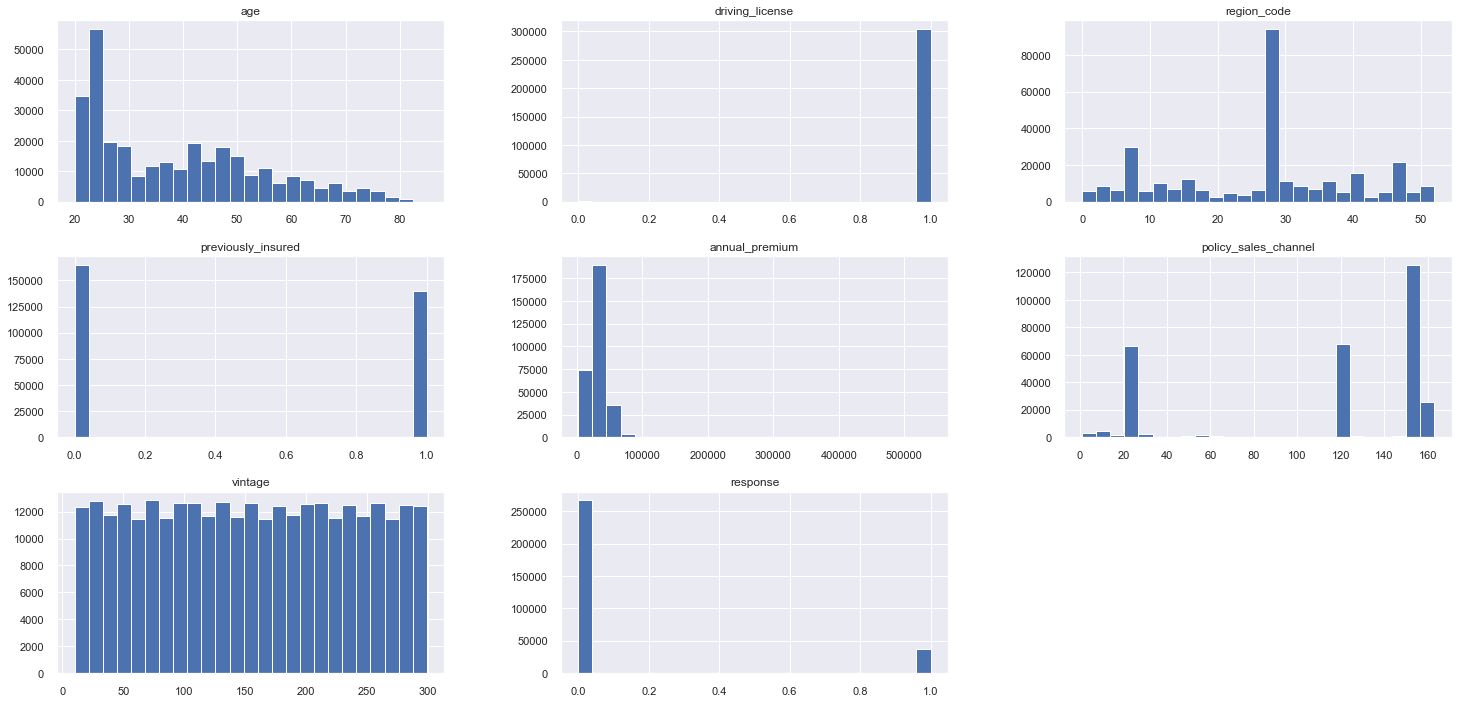

In [23]:
# Plot attributes numericals
num_attributes.drop(columns = ['id'], inplace = True)
num_attributes.hist(bins=25);

### 1.5.2 Categorical Atributtes

In [24]:
cat_attributes.describe()

,gender,vehicle_age,vehicle_damage
count,304693,304693,304693
unique,2,3,2
top,Male,1-2 Year,Yes
freq,164769,160167,153934


In [25]:
# Valores distintos das colunas
print(f"- Distinct values:\n{cat_attributes.apply( lambda x: x.unique().shape[0] ) } \n" )
print(f"- Variations:\n{cat_attributes.apply( lambda x: x.unique() ) } " )

- Distinct values:
gender            2
vehicle_age       3
vehicle_damage    2
dtype: int64 

- Variations:
gender                             [Male, Female]
vehicle_age       [> 2 Years, 1-2 Year, < 1 Year]
vehicle_damage                          [Yes, No]
dtype: object 


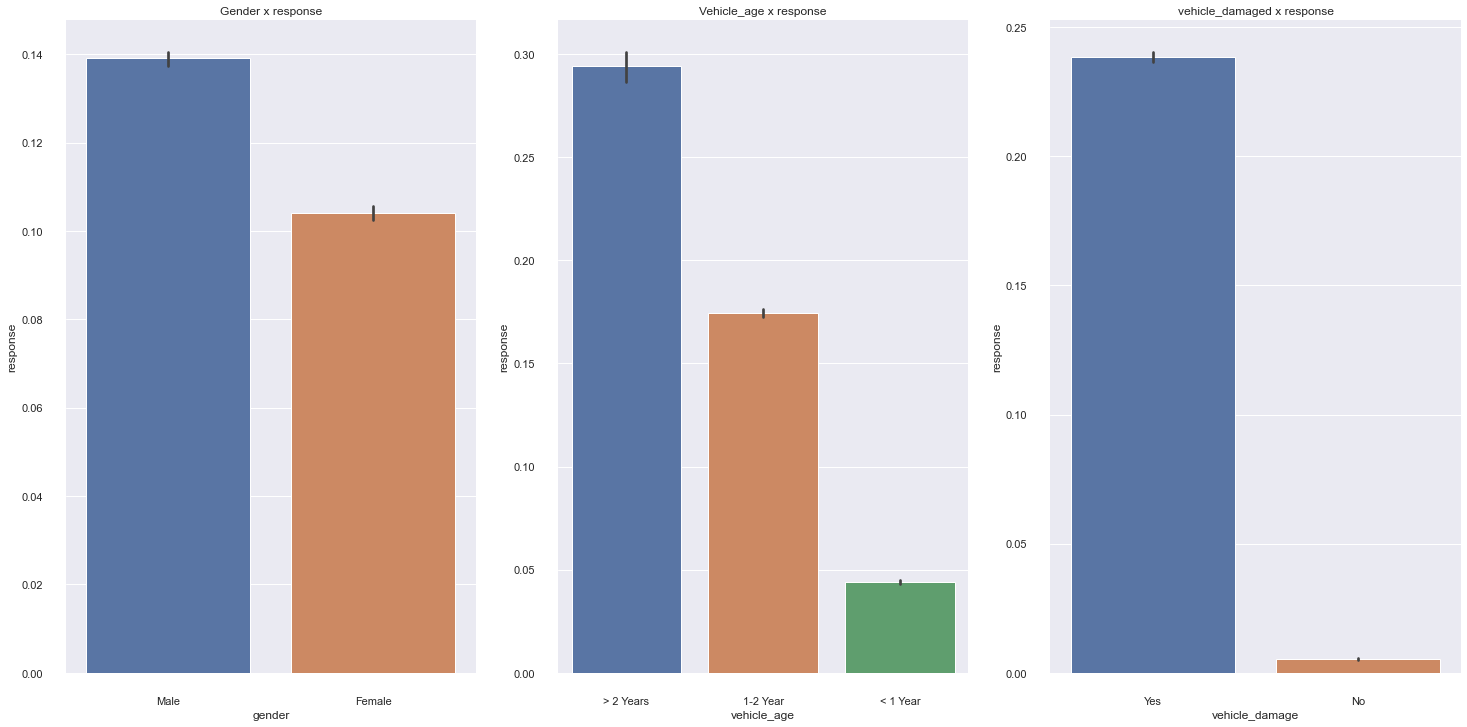

In [26]:
# Plot variáveis categóricas
plt.subplot( 1, 3, 1 )
sns.barplot( x='gender', y='response', data=df1 )
sns.despine(offset = 10, trim = True)
plt.title('Gender x response')

plt.subplot( 1, 3, 2 )
sns.barplot( x='vehicle_age', y='response', data=df1 )
sns.despine(offset = 10, trim = True)
plt.title('Vehicle_age x response')

plt.subplot( 1, 3, 3 )
sns.barplot( x='vehicle_damage', y='response', data=df1 )
sns.despine(offset = 10, trim = True)
plt.title('vehicle_damaged x response');

In [ ]:
# Anotações sobre as primeiras observações:
a) A variável resposta está desbalanceada (há menos interessados em adquirir o produto)
b) Quase todas as pessoas da base tem licença para dirigir (carteira de habilitação)
c) Aproximadamente a metade das pessoas já tem o seguro de carro
d) Um pouco mais que a metade das pessoas tem um gasto anual de 50000 com o plano de saúde, sendo a média em torno de 30500
e) Em torno de 40% das pessoas, a idade está na faixa até 30 anos e a média está em 38 anos
f) A idade está em um range de 20 e 85 anos
g) A  maioria da base é masculina
h) O tempo de vigência de contrato do seguro de vida está entre 10 e 299 dias, sendo a média 154 dias
i) 99.8% das pessoas da base tem licença para dirigir
j) A maioria dos veículos já sofreram algum tipo de dano

## 1.6 Column Dictionary

In [ ]:
* id: identificador único do cliente.
* age: idade do cliente
* driving_licence: O cliente possui licença para dirigir (0=não, 1 = sim)
* region_code: código da região do cliente
* previously_insured: se o cliente já tem o seguro de carro (0=não, 1 = sim)
* Vehicle Age: idade do veículo.
* Vehicle Damage: 0, cliente nunca teve seu veículo danificado no passado e 1, cliente já teve seu veículo danificado no passado.
* annual_premium: Qual valor de pagamento anual do seguro que o cliente pagou para a empresa
* policy_sales_channel: canal de contato de preferência do cliente
* vintage: tempo que a pessoa é cliente da empresa (em dias) a partir da compra do seguro de saúde
* response: variável resposta (previsão) - interesse do cliente em adquirir o seguro de carro (sim=1, não=0)

## 2.0 Feature engineering

In [27]:
df2 = df1.copy()

## 2.1 Hypotheses Mindmap

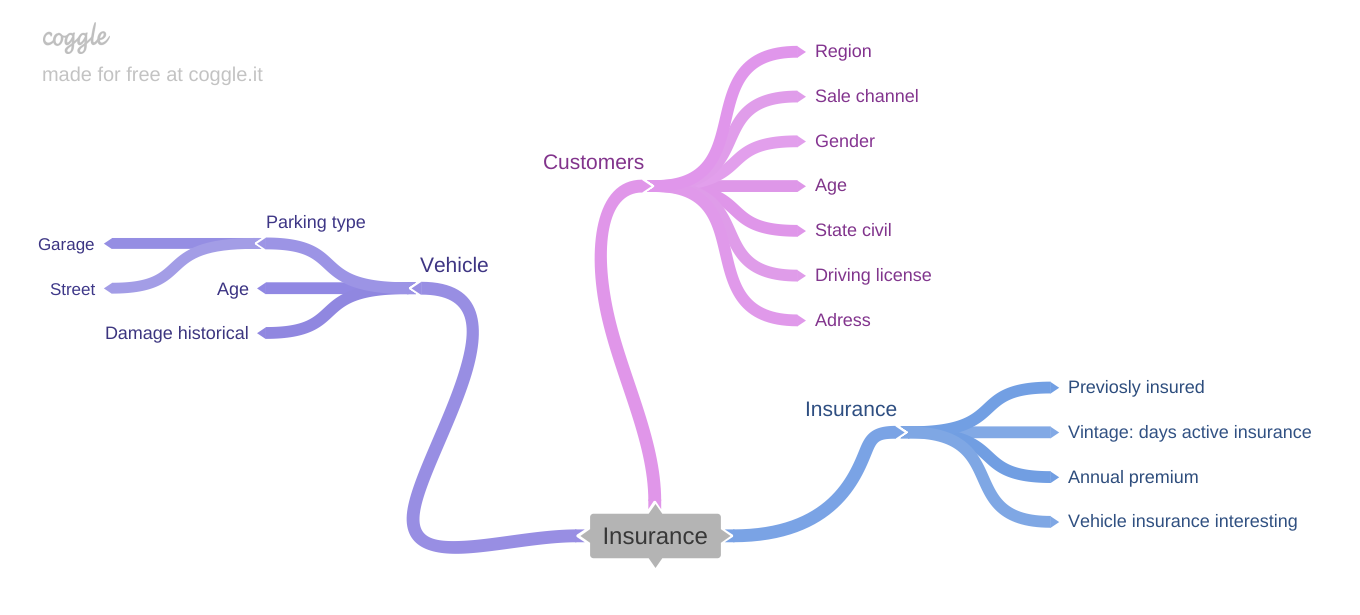

In [28]:
Image('C:\Repos\pa004\image\Insurance.png')

## 2.2 Hypothesis creation

**H1 -** Mulheres tem mais interesse em comprar seguro de veículos que homens.
 
 **H2 -** Clientes com carros novos/seminovos (menor que 2 anos), tem mais interesse em seguro de veículos.
 
 **H3 -** Clientes sem carteira de motorista não tem interesse algum em seguro de veículos.
 
 **H4 -** Clientes que ja sofreram algum acidente tem mais interesse em adquirir seguro de veículos.
 
 **H5 -** Clientes acima de 30 anos são mais interessados em adquirir seguro de veículos. 
 
 **H6 -** Clientes que pagaram entre 30000 e 40000 para serem premium no ano(Annual Premium) tem mais interesse em adquirir seguro de veículos.
 
 **H7 -** Homens tem mais eventos de dano a veículos, do que mulheres. 
 
 As pessoas estão igualmente interessadas em seguros, independentemente do seu género
FALSO Quanto mais velho o veículo, maior é o interesse em adquirir um seguro
Se o proprietário danificou seu veículo antes, é mais provável que ele adquira um seguro
TRUEPeople quem tem carta de condução estão mais interessados em seguro
FALSO

Diferentes regiões têm diferentes interesses em seguros
TRUEDifferent canal de vendas de política têm resultado diferente para o cliente
TRUEWho foi anteriormente segurado é menos provável que adquira um novo serviço de seguro (já tinha mostrado compromisso)
VERDADEIROO Prêmio Anual mais alto, menor o interesse em seguros
FALSOA safra maior, maior o interesse em seguros
FALSOA idade mais alta, maior o interesse em seguros
VERDADEIRO

## 2.3 Feature engineering

In [29]:
# Idade do veículos
df2['vehicle_age'] =  df2['vehicle_age'].apply( lambda x: 'over_2_years' if x == '> 2 Years' else 'between_1_2_year' if x == '1-2 Year' else 'below_1_year' )

# Se o veículo já sofreu algum dano
df2['vehicle_damage'] = df2['vehicle_damage'].apply(lambda x: 1 if x=='Yes' else 0)

In [30]:
df2.head()

,id,gender,age,driving_license,region_code,previously_insured,vehicle_age,vehicle_damage,annual_premium,policy_sales_channel,vintage,response
0,1,Male,44,1,28.0,0,over_2_years,1,40454.0,26.0,217,1
1,2,Male,76,1,3.0,0,between_1_2_year,0,33536.0,26.0,183,0
2,3,Male,47,1,28.0,0,over_2_years,1,38294.0,26.0,27,1
6,7,Male,23,1,11.0,0,below_1_year,1,23367.0,152.0,249,0
8,9,Female,24,1,3.0,1,below_1_year,0,27619.0,152.0,28,0


## 3.0 Data Filtering

In [31]:
df3 = df2.copy()
# Não foi necessária a aplicação de filtro 

## 4.0 EDA - Exploration Data Analysis

In [32]:
df4 = df3.copy()

## 4.1 Univariate Analysis
###### # Principal análise dos gráficos -> amplitude e shape

In [33]:
df4.columns

Index(['id', 'gender', 'age', 'driving_license', 'region_code',
       'previously_insured', 'vehicle_age', 'vehicle_damage', 'annual_premium',
       'policy_sales_channel', 'vintage', 'response'],
      dtype='object')

### 4.1.1 Response variable

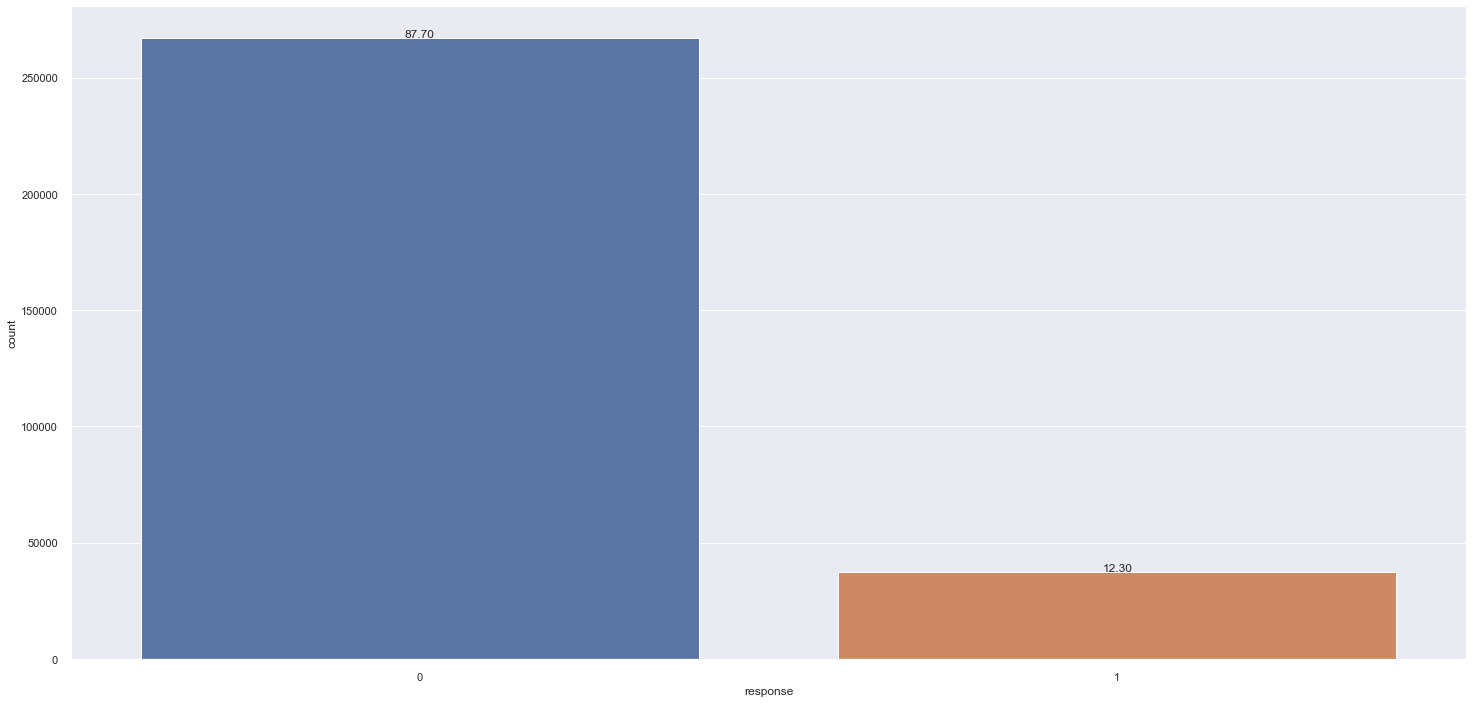

In [34]:
## Nota: a variável resposta está desbalanceada (temos a maioria das pessoas não interessadas em um novo seguro)
ax=sns.countplot(df4['response'])
total=len(df4['response'])
graphic_percentage(ax,total)

### 4.1.2 Age

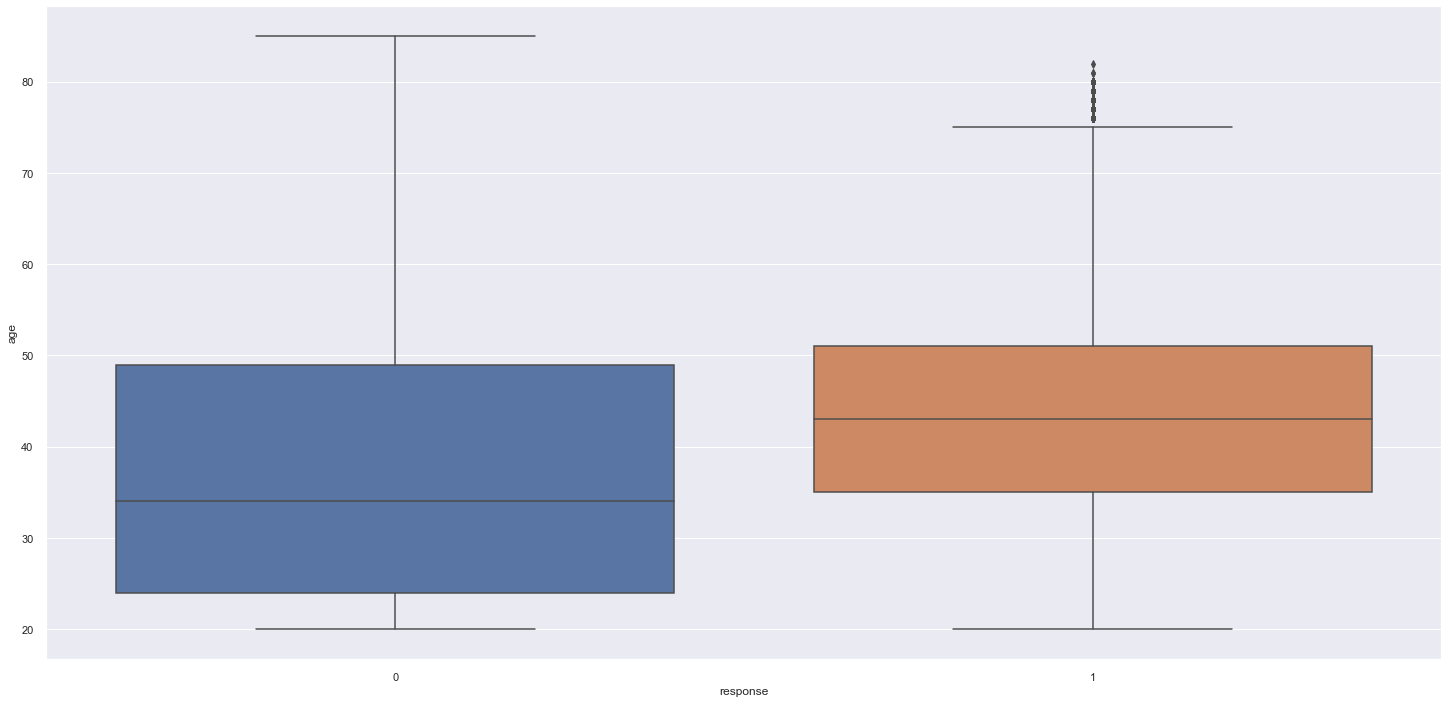

In [35]:
## Nota: Em média, pessoas mais velhas tem mais interesse em seguro de carro
sns.boxplot(x='response', y='age', data=df4)


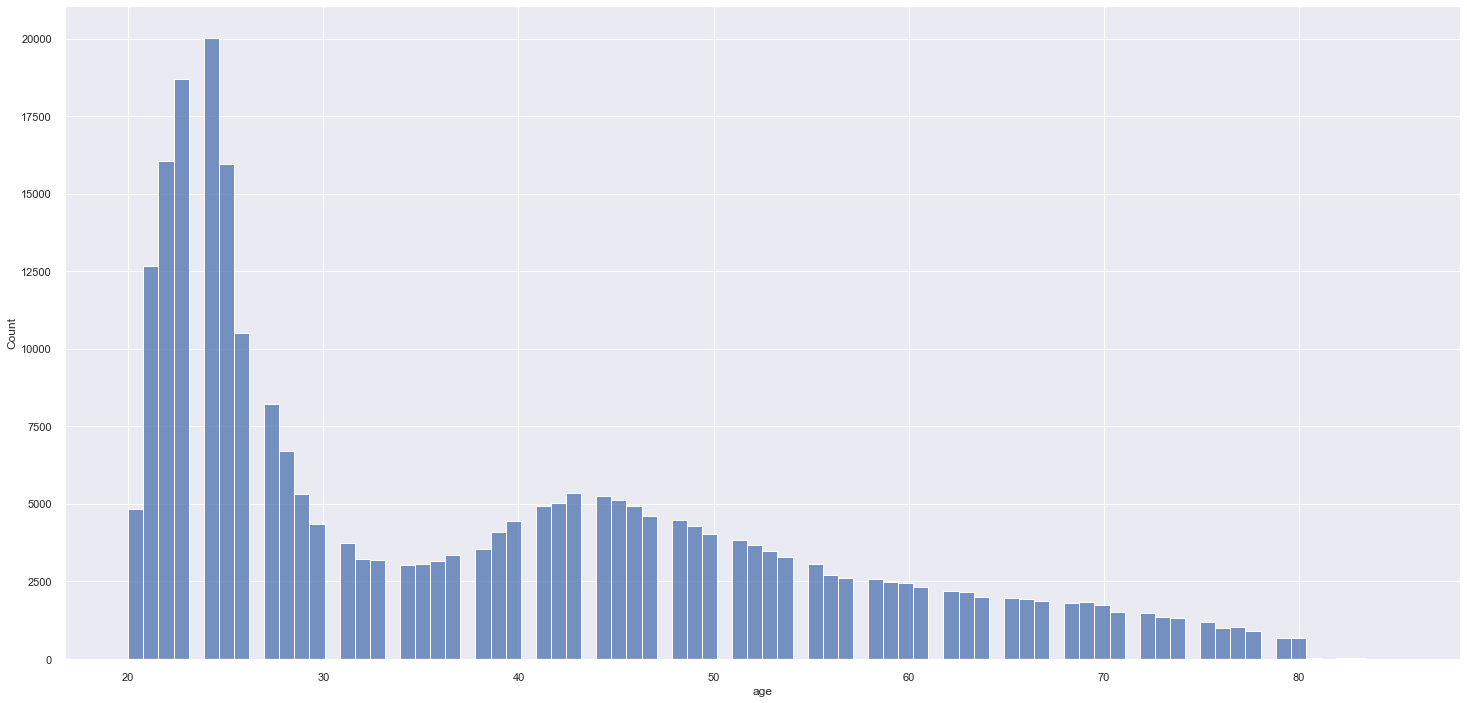

In [36]:
# Histograma da distribuição da idade: não tem interesse em um seguro de carro
# Observa-se que nas pessoas mais novas a curva é maior e tem uma cauda em decaimento
# Não é uma distribuição normal, é uma poison

aux00 = df4.loc[df4['response'] == 0, 'age']
sns.histplot(aux00)

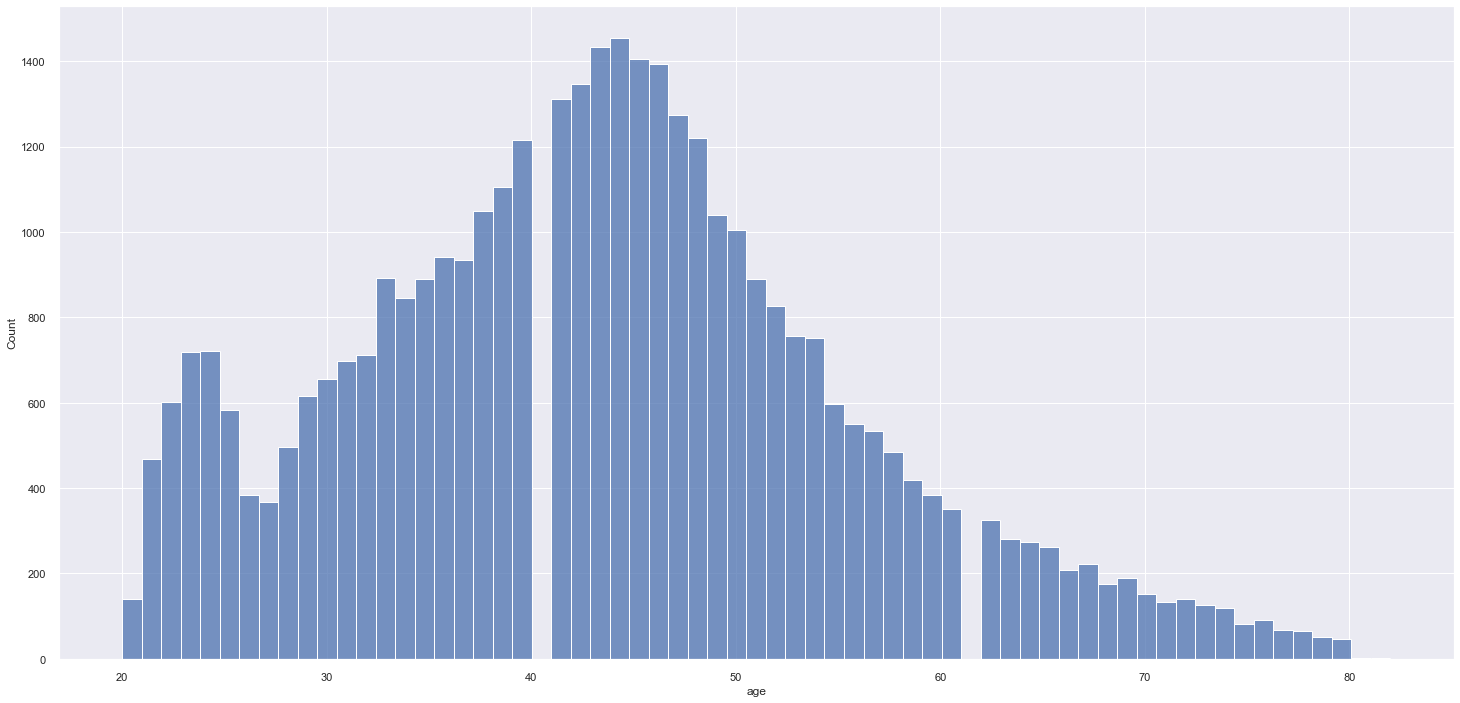

In [37]:
# Histograma da distribuição da idade: pessoas que tem interesse em um seguro de carro
# Nota: Há uma concentração de pessoas mais velhas que querem o seguro de carro
# Alerta: esatou observando os dados desbalanceados: tenho muito mais dados que representam o fenômeno de quem não quer o seguro do que aqueles que querem o seguro

aux00 = df4.loc[df4['response'] == 1, 'age']
sns.histplot(aux00)

### 4.1.3 Annual investment in health insurance

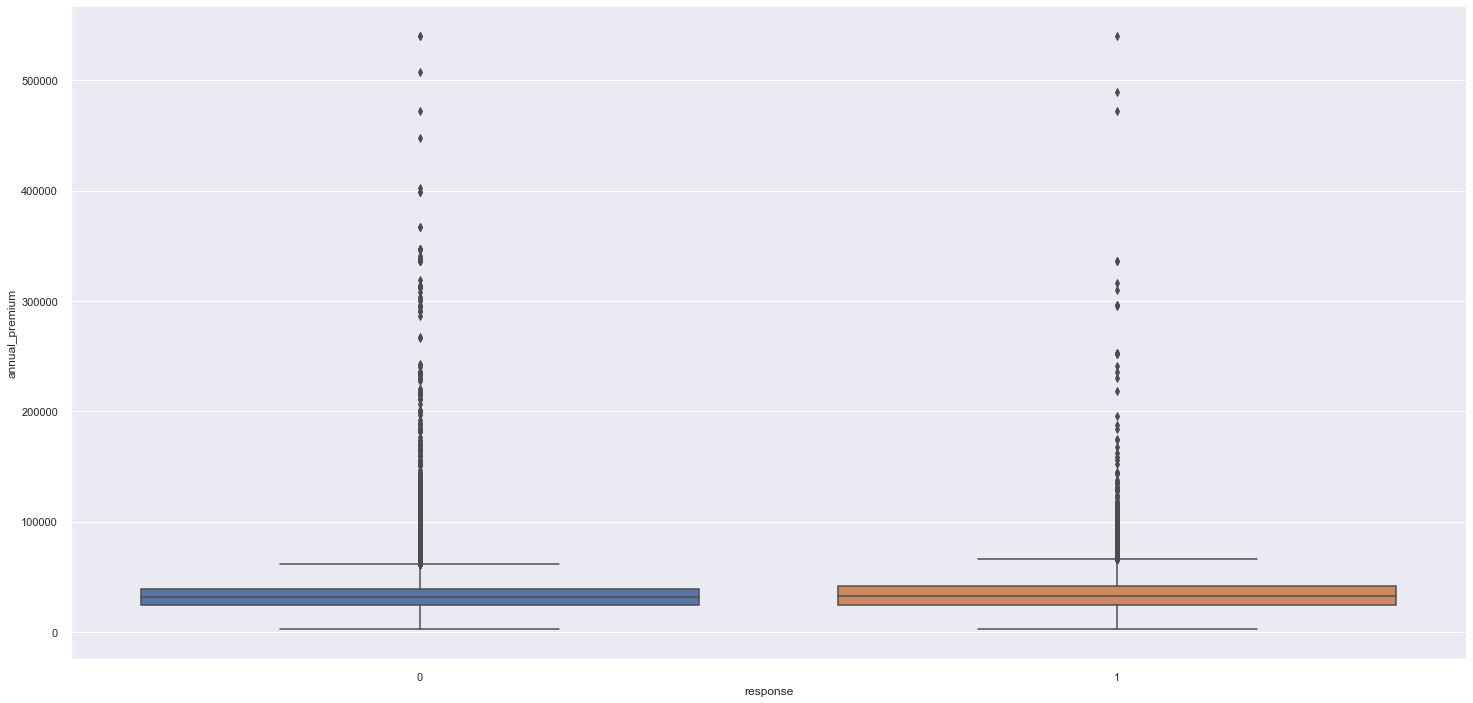

In [39]:
# Sem filtro: não é possível ter clareza
sns.boxplot( x='response', y='annual_premium', data=df4 )

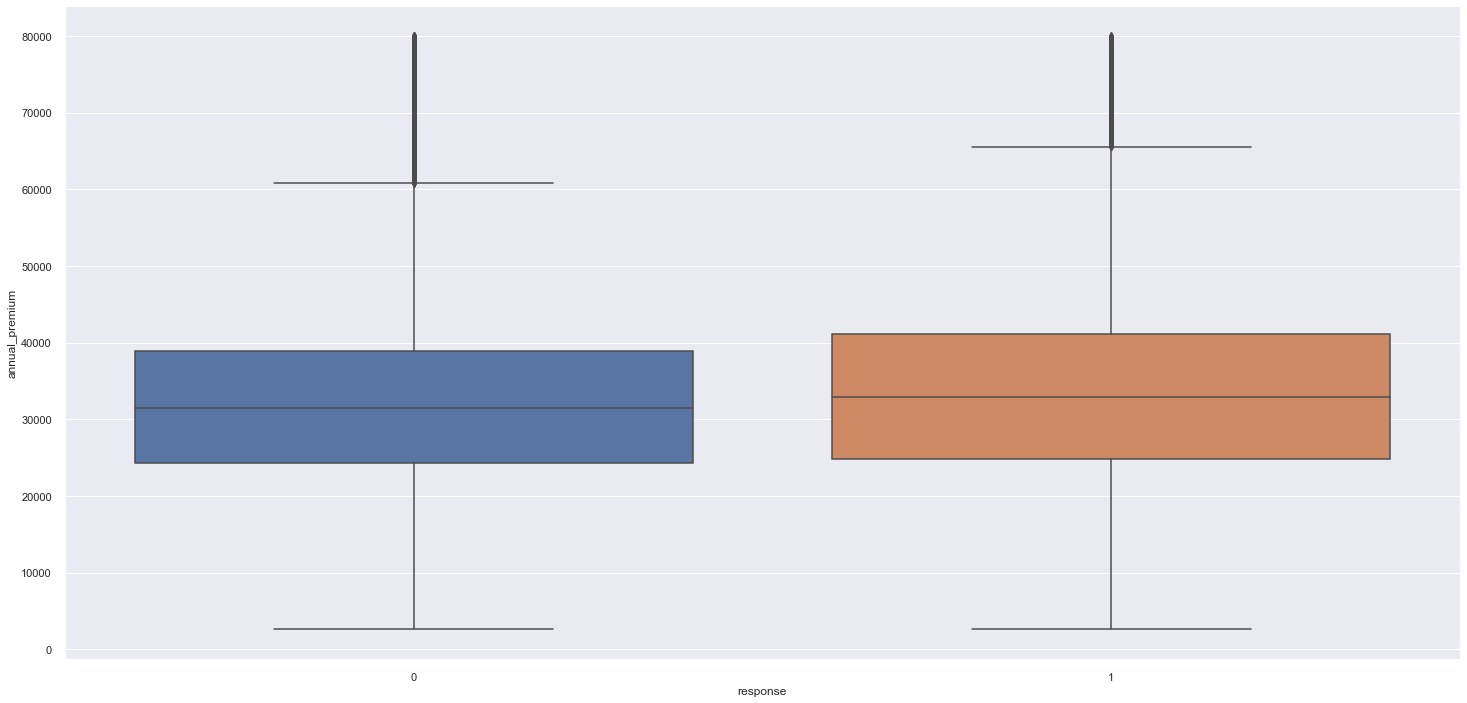

In [40]:
# Aplicação do filtro 1 (gasto anual menor que 80.000) - Necessidade do filtro, porque há dificuldade de ver, tem muito outlier
# Nota: A média é muito semelhante de gasto anual com seguro-saúde para interessados e não interessados em um novo seguro

aux = df4[df4['annual_premium'] < 80000]
sns.boxplot(x='response', y='annual_premium', data=aux)

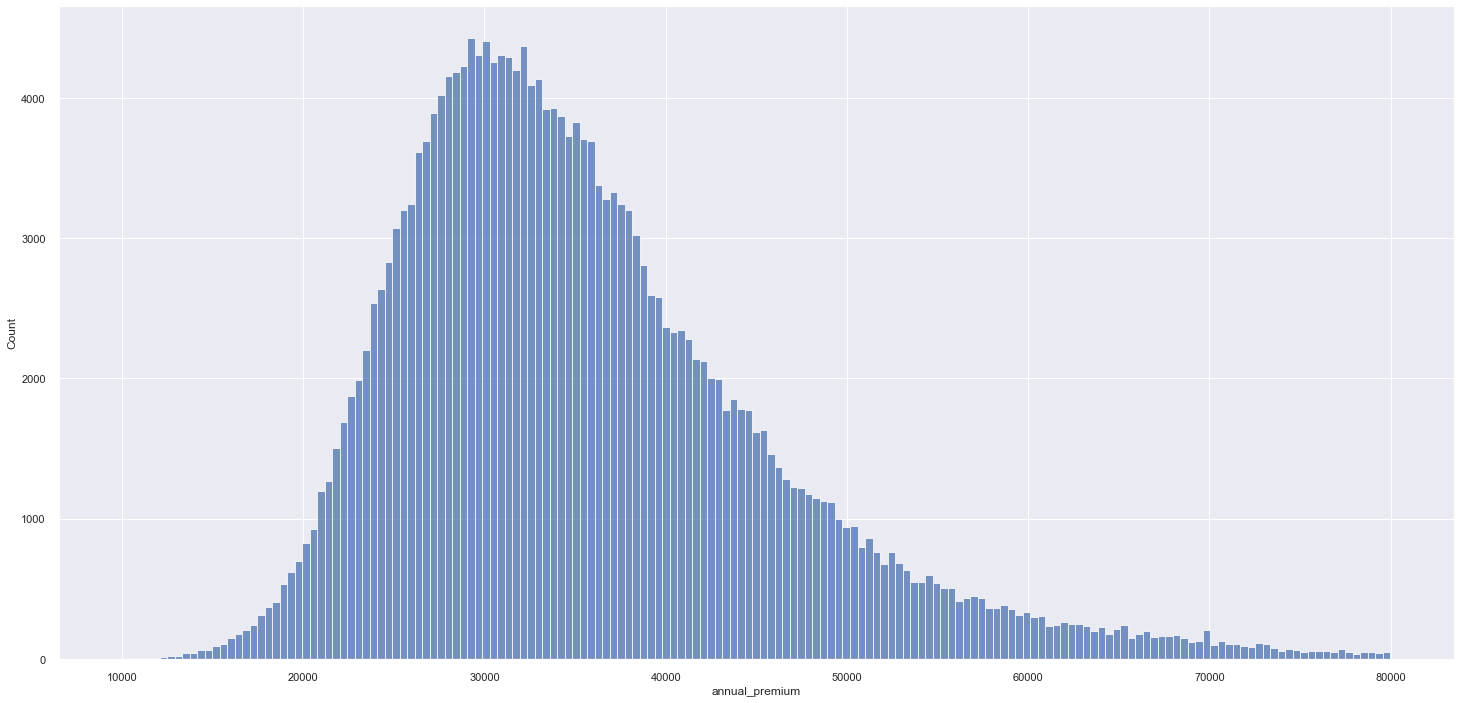

In [41]:
# Aplicação do filtro 2:  Concentração de pessoas que não querem o novo seguro e que pagam entre 10.000 e 80.000
aux = df4[(df4['annual_premium'] > 10000) & (df4['annual_premium'] < 80000)]
aux00 = aux.loc[aux['response'] == 0, 'annual_premium']
sns.histplot(aux00)

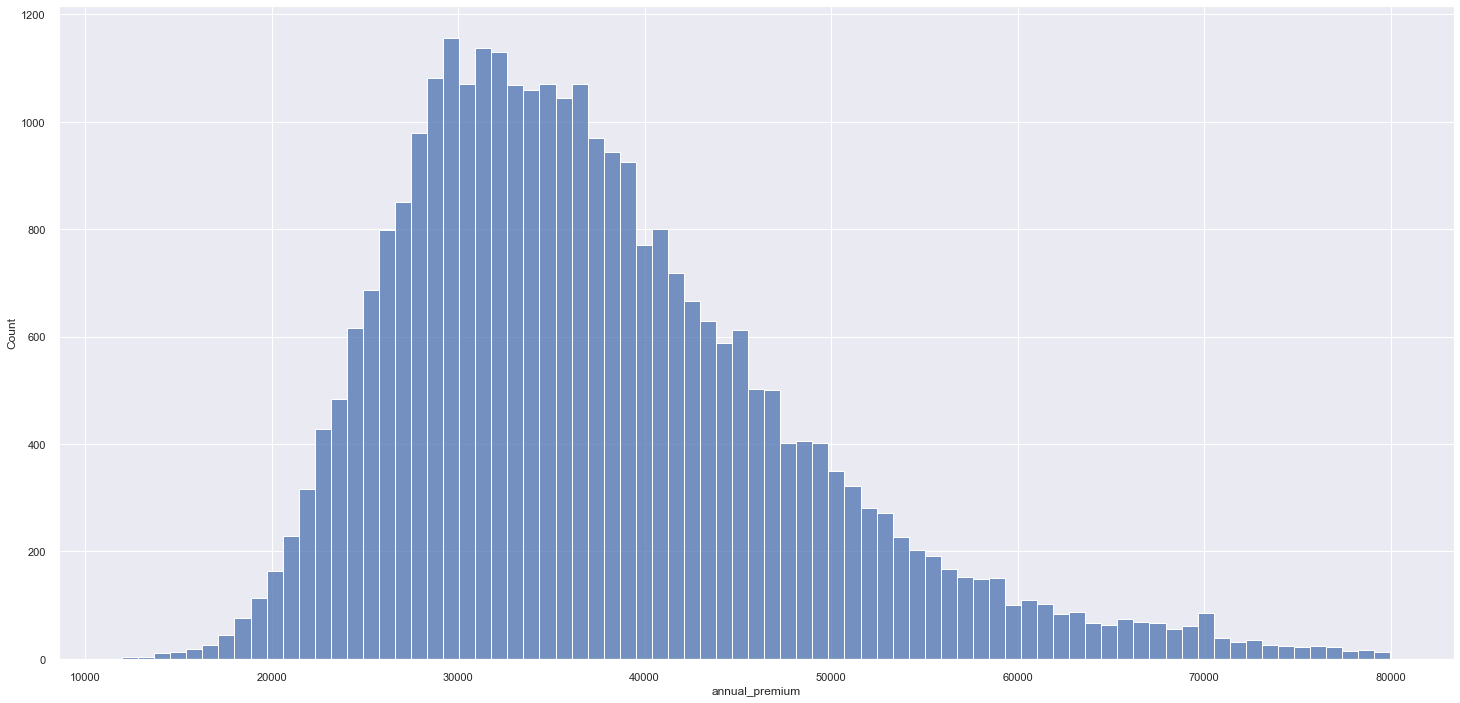

In [42]:
# Aplicação do filtro 3:  Concentração de pessoas que querem o novo seguro e que pagam entre 10.000 e 80.000
# As duas curvas são semelhantes, a mediana delas é bastante parecida
aux = df4[(df4['annual_premium'] > 10000) & (df4['annual_premium'] < 80000)]
aux00 = aux.loc[aux['response'] == 1, 'annual_premium']
sns.histplot(aux00);

### 4.1.4 Driving license

In [43]:
# Considerando que o dataset está desbalanceado, observa-se mais pessoas que possuem carteira de motorista, não estão interessadas em um novo seguro
aux = df4[['driving_license', 'response']].groupby('response').sum().reset_index()
aux.head()

,response,driving_license
0,0,266587
1,1,37451


In [44]:
# 87% das pessoas que dirigem não querem o seguro e 12% querem o seguro
aux['driving_license_perc'] = aux['driving_license']/aux['driving_license'].sum()
aux

,response,driving_license,driving_license_perc
0,0,266587,0.876821
1,1,37451,0.123179


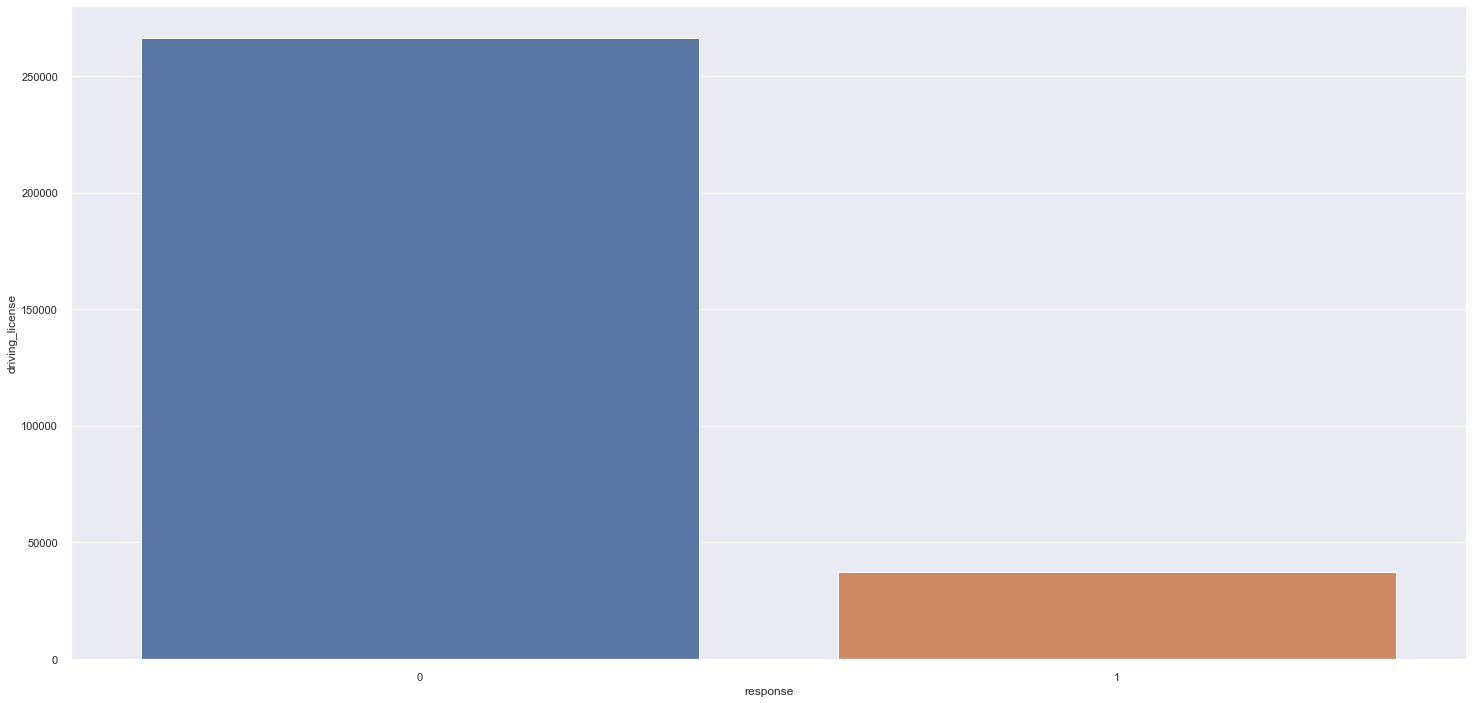

In [45]:
sns.barplot(x='response', y='driving_license', data=aux);

### 4.1.5 Region Code

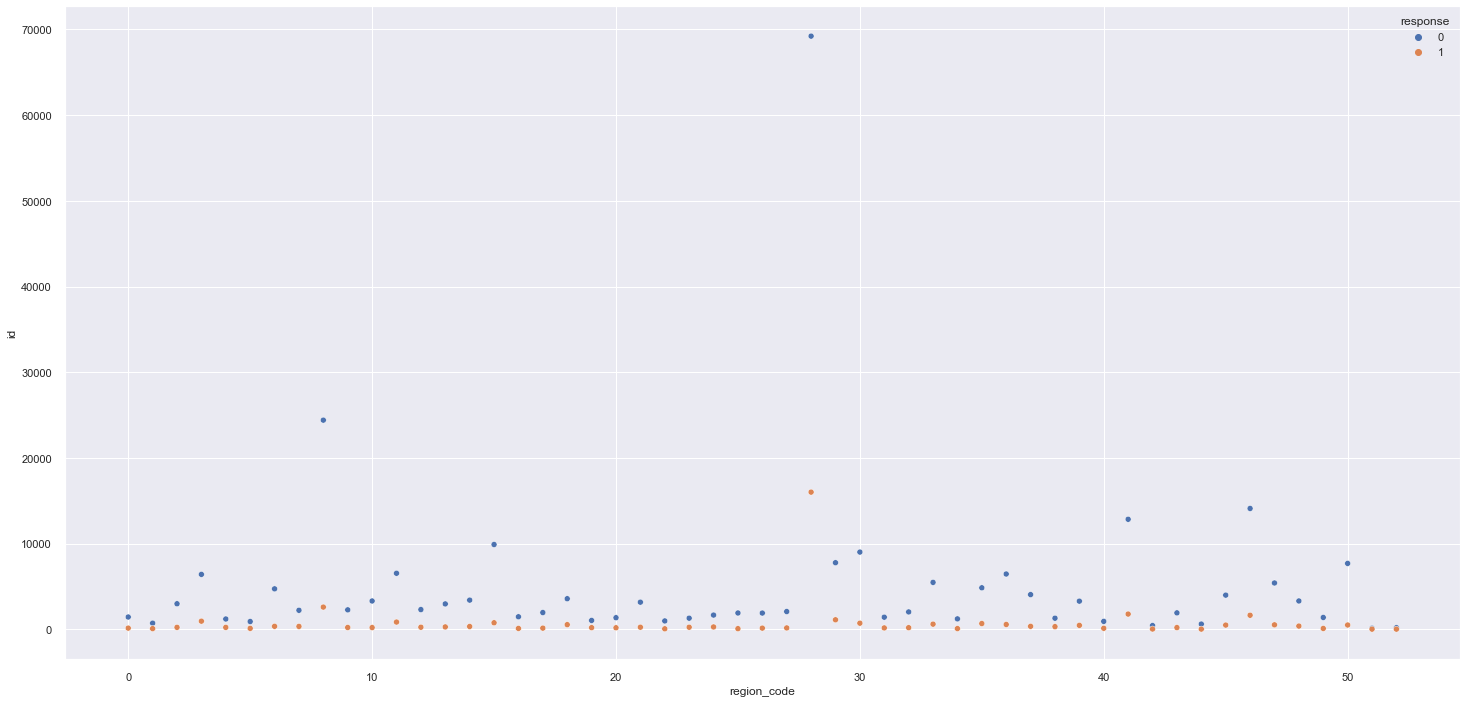

In [46]:
# Separando as regiões em cores, para descobrir se existem grupos (scatterplot)
aux0 = df4[['id','region_code', 'response']].groupby(['region_code', 'response']).count().reset_index()
# aux0 = aux0[(aux0['id'] > 1000) & (aux0['id'] < 20000)]
sns.scatterplot(x='region_code', y='id', hue='response', data=aux0)

### 4.1.6 Previously insured

In [47]:
# Cruzamento das pessoas que já tem o seguro de carro x querem o novo seguro de carro)
# Obs: Esse dado está muito relacionado com  a variável resposta, pode ser que exista um vazamento de dados
pd.crosstab(df4['previously_insured'],df4['response']).apply(lambda x: x/ x.sum(), axis=1)

response,0,1
previously_insured,,
0,0.773744,0.226256
1,0.999097,0.000903


### 4.1.7 Vehicle age

In [48]:
# Existem 3 categorias para o tempo de uso dos veículos
# A grande maioria é mais novo que 2 anos
df4['vehicle_age'].unique()

array(['over_2_years', 'between_1_2_year', 'below_1_year'], dtype=object)

In [49]:
# vehicle_age (percentual de interessados e não interessados x ano do veículo)
df4[['vehicle_age','response']].value_counts(normalize=True).reset_index()

,vehicle_age,response,0
0,between_1_2_year,0,0.433952
1,below_1_year,0,0.413501
2,between_1_2_year,1,0.091715
3,over_2_years,0,0.029522
4,below_1_year,1,0.019006
5,over_2_years,1,0.012304


In [50]:
# vehicle_age (total de interessados e não interessados x ano do veículo)
df4[['id','vehicle_age', 'response']].groupby( ['vehicle_age', 'response'] ).count().reset_index()

,vehicle_age,response,id
0,below_1_year,0,125991
1,below_1_year,1,5791
2,between_1_2_year,0,132222
3,between_1_2_year,1,27945
4,over_2_years,0,8995
5,over_2_years,1,3749


### 4.1.8 Vehicle damage 

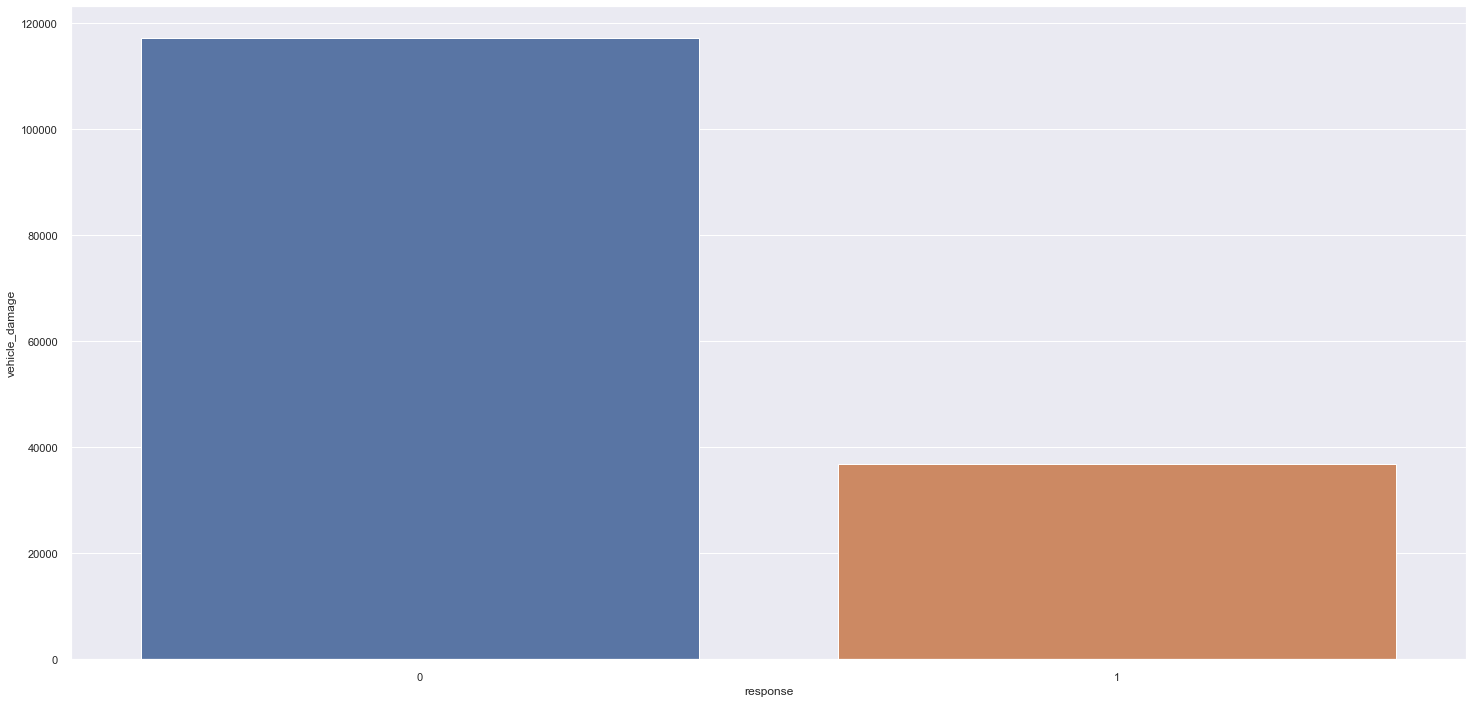

In [51]:
# A maioria dos veículos já teve algum tipo de dano e não quer seguro
aux = df4[['vehicle_damage', 'response']].groupby( 'response' ).sum().reset_index()
sns.barplot( x='response', y='vehicle_damage', data=aux );

### 4.1.9 Policy sales channel (tipo de contato que a pessoa aceita receber)

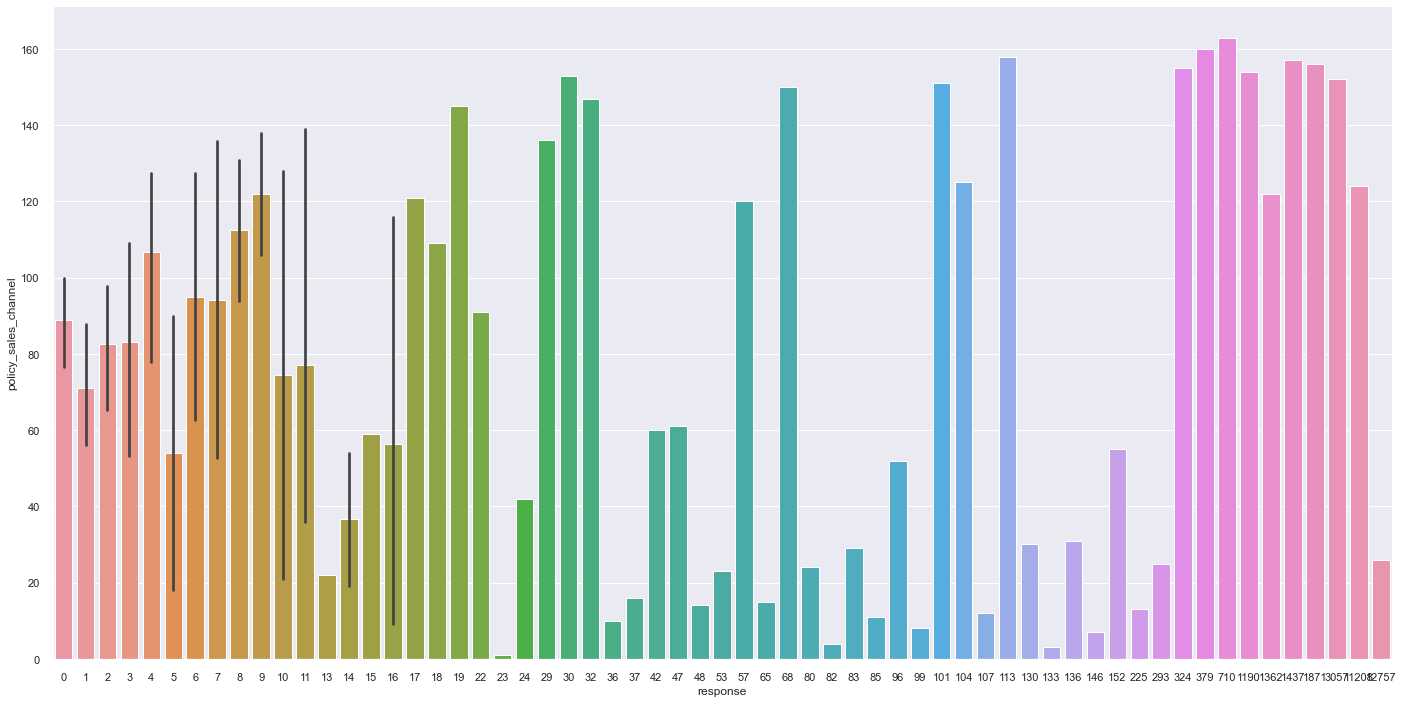

In [52]:
# policy_sales_channel (tipo de contato que a pessoa quer receber)
aux = df4[['policy_sales_channel','response']].groupby('policy_sales_channel').sum().reset_index()
plt.figure(figsize=(24,12))
sns.barplot(x='response', y='policy_sales_channel', data=aux)

In [53]:
## Os códigos das formas que as pessoas aceitam receber o contato variam muito; provavelmente não tem impacto na venda do novo seguro
aux01 = df4[['policy_sales_channel', 'response']].groupby( 'policy_sales_channel' ).sum().reset_index()
aux02 = df4[['id', 'policy_sales_channel']].groupby( 'policy_sales_channel' ).size().reset_index().rename( columns={0:'total_responses'})

aux = pd.merge( aux01, aux02, how='inner', on='policy_sales_channel' )
aux

,policy_sales_channel,response,total_responses
0,1.0,23,875
1,2.0,1,3
2,3.0,133,430
3,4.0,82,404
4,6.0,0,3
5,7.0,146,1266
6,8.0,99,1219
7,9.0,16,134
8,10.0,36,210
9,11.0,85,969


### 4.1.10 Vintage (quanto tempo a pessoa está em contrato vigente - dias)

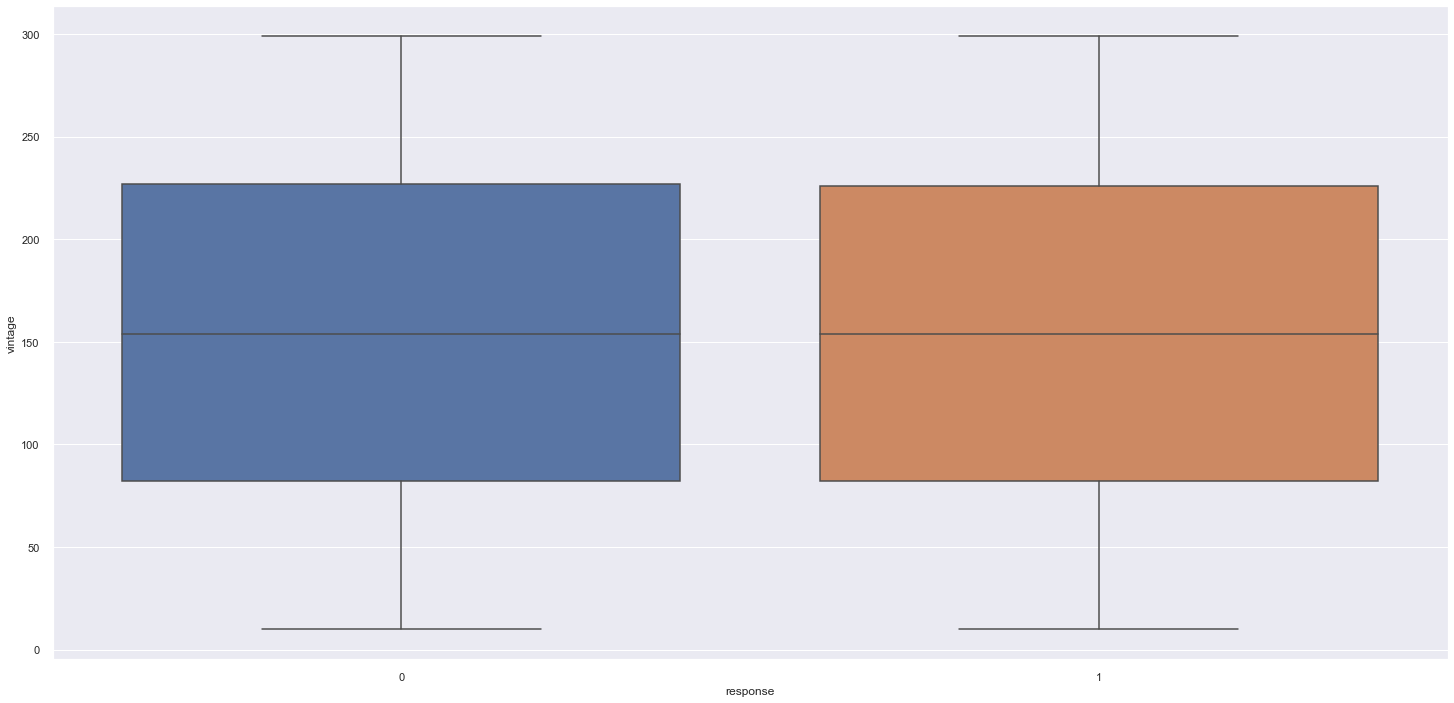

In [54]:
# Percebe-se que a média de pessoas interessadas ou não em um novo seguro é muito semelhante, observando o tempo que são clientes (a média é muito uniforme) 
sns.boxplot(x='response', y='vintage', data=df4)

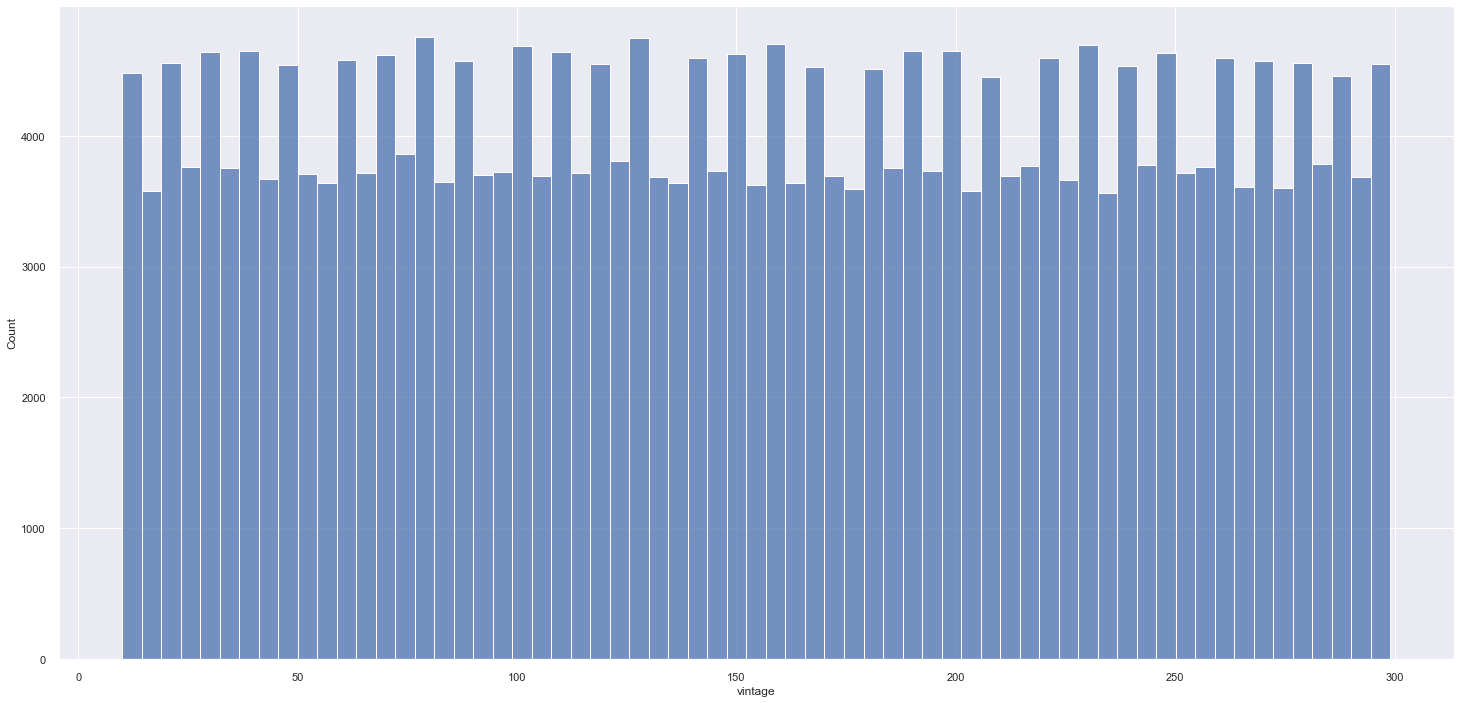

In [55]:
# Pessoas não interessados em relação ao tempo que são clientes
aux00 = df4.loc[df4['response']==0, 'vintage']
sns.histplot(aux00)

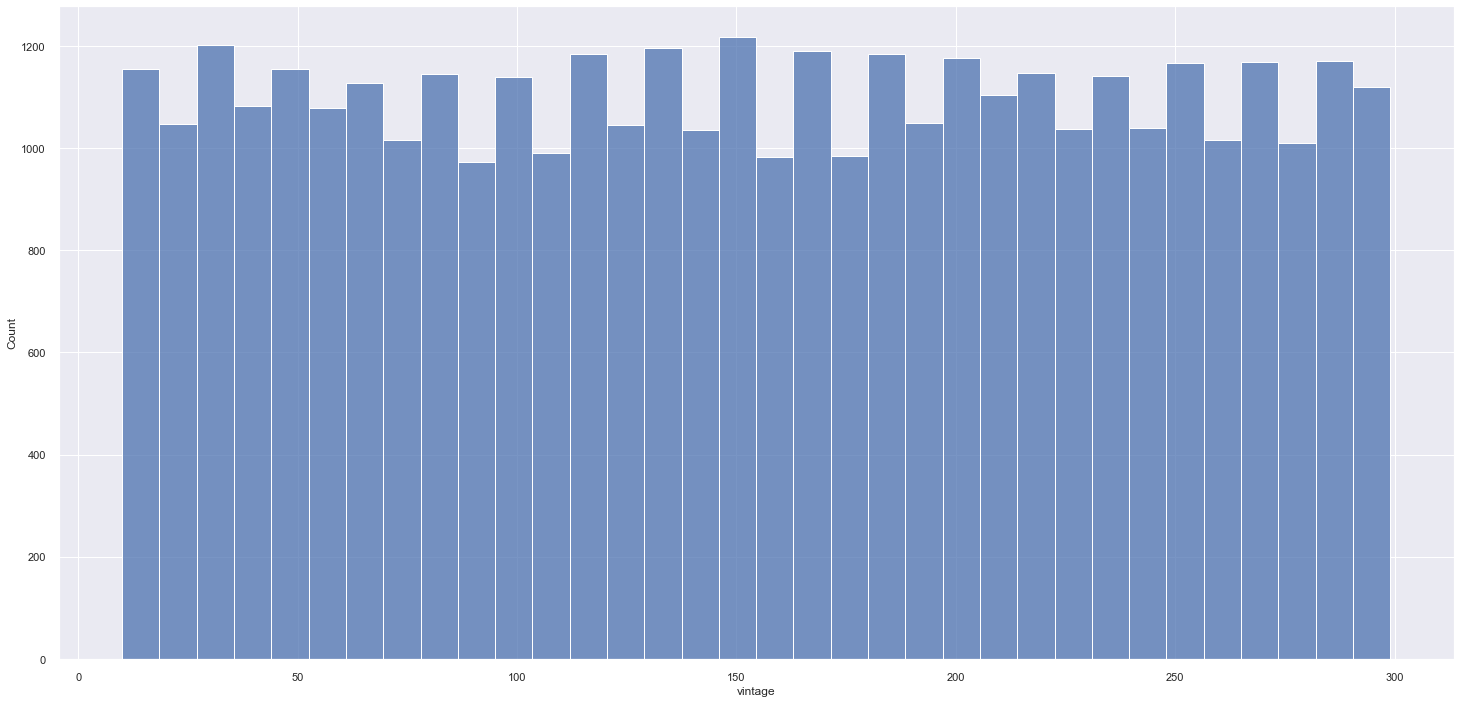

In [56]:
# Pessoas interessados em relação ao tempo que são clientes
aux00 = df4.loc[df4['response']==1, 'vintage']
sns.histplot(aux00)

### 4.1.11 Gender

In [57]:
# Gênero x interessados ou não (percentual)
aux=df4[['gender', 'response']].value_counts( normalize=True ).reset_index()
aux.columns=[['gender','response','percentage']]
aux

,gender,response,percentage
0,Male,0,0.465567
1,Female,0,0.411408
2,Male,1,0.075204
3,Female,1,0.047822


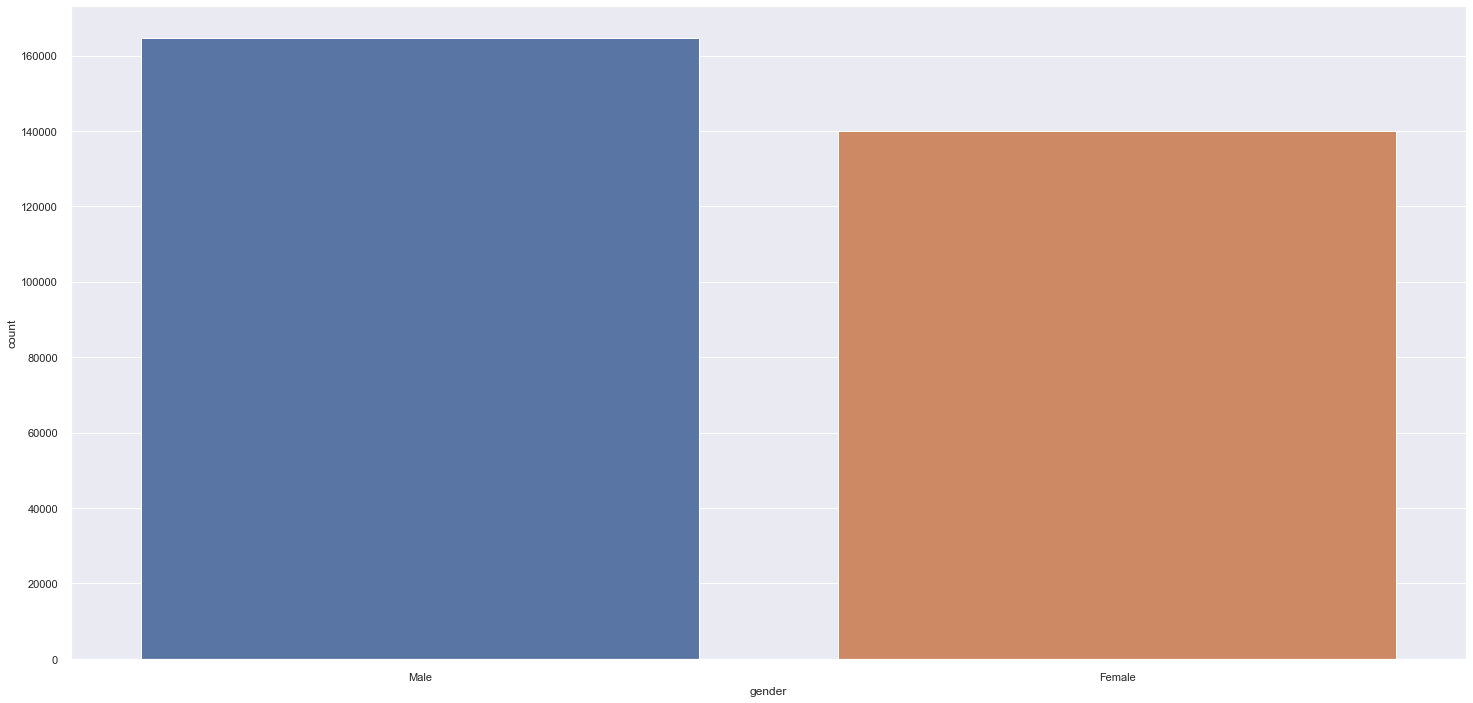

In [58]:
sns.countplot ( df4['gender']);

## 4.2 Bivariada Analysis

### H1- Homens e mulheres tem o mesmo interesse em adquirir o seguro de veículo
**Falsa** - Do total de 266914 pessoas que estão na base e estão interessadas no seguro, os homens representam (61,1%), enquanto as mulheres, (38,9%)

In [59]:
df4[['id','gender', 'response']].groupby( ['gender', 'response'] ).count().reset_index()

,gender,response,id
0,Female,0,125353
1,Female,1,14571
2,Male,0,141855
3,Male,1,22914


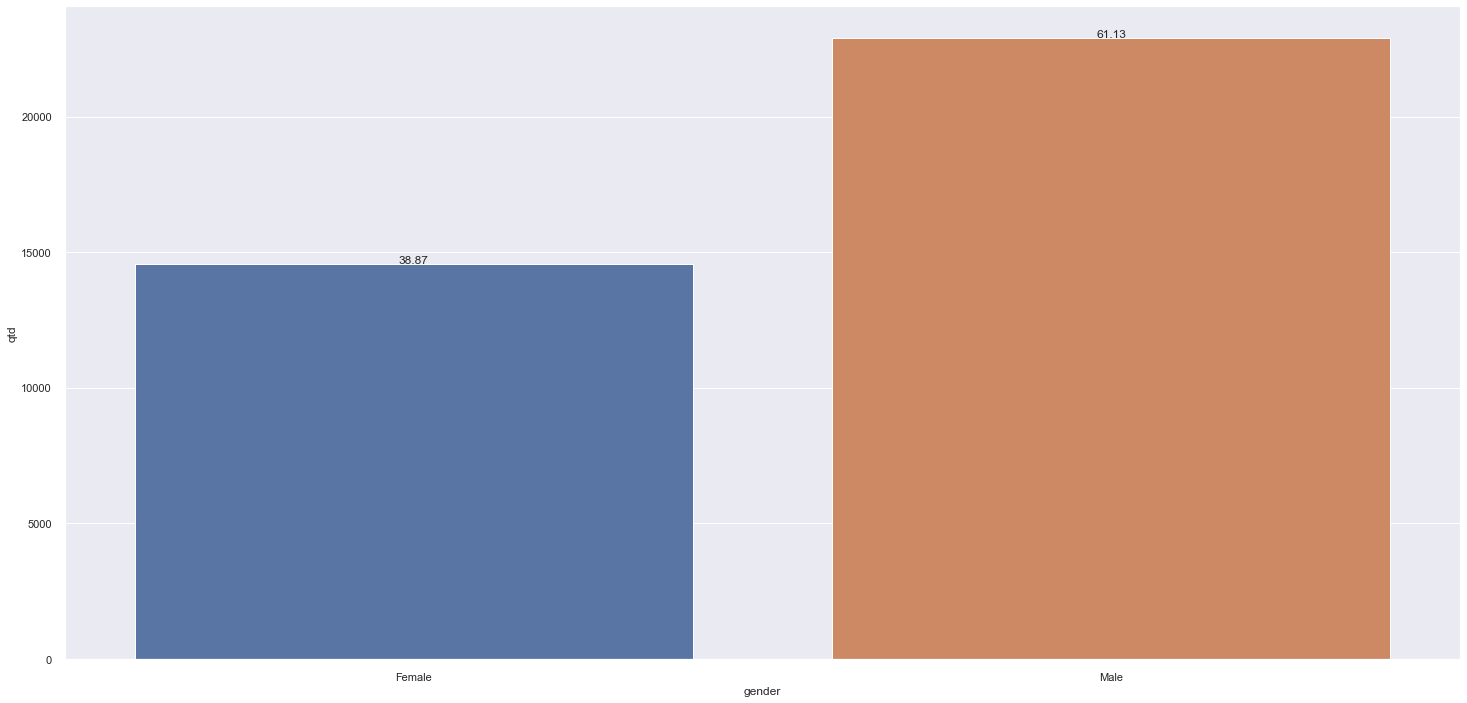

In [60]:
aux=df4[df4['response']==1]
aux=aux[['gender']].groupby('gender').size().reset_index().rename(columns={0:'qtd'})
ax=sns.barplot(data=aux,x='gender',y='qtd')
total=sum(aux['qtd'])
graphic_percentage(ax,total)

### H2 - Clientes que já sofreram algum tipo de dano em seu carro, tem mais interesse em adquirir um seguro de carro
**Verdadeira** - 97.9% das pessoas interessadas já sofreram algum tipo de dano/acidente no seu carro

In [61]:
df4[['id','vehicle_damage', 'response']].groupby( ['vehicle_damage', 'response'] ).count().reset_index()

,vehicle_damage,response,id
0,0,0,149977
1,0,1,782
2,1,0,117231
3,1,1,36703


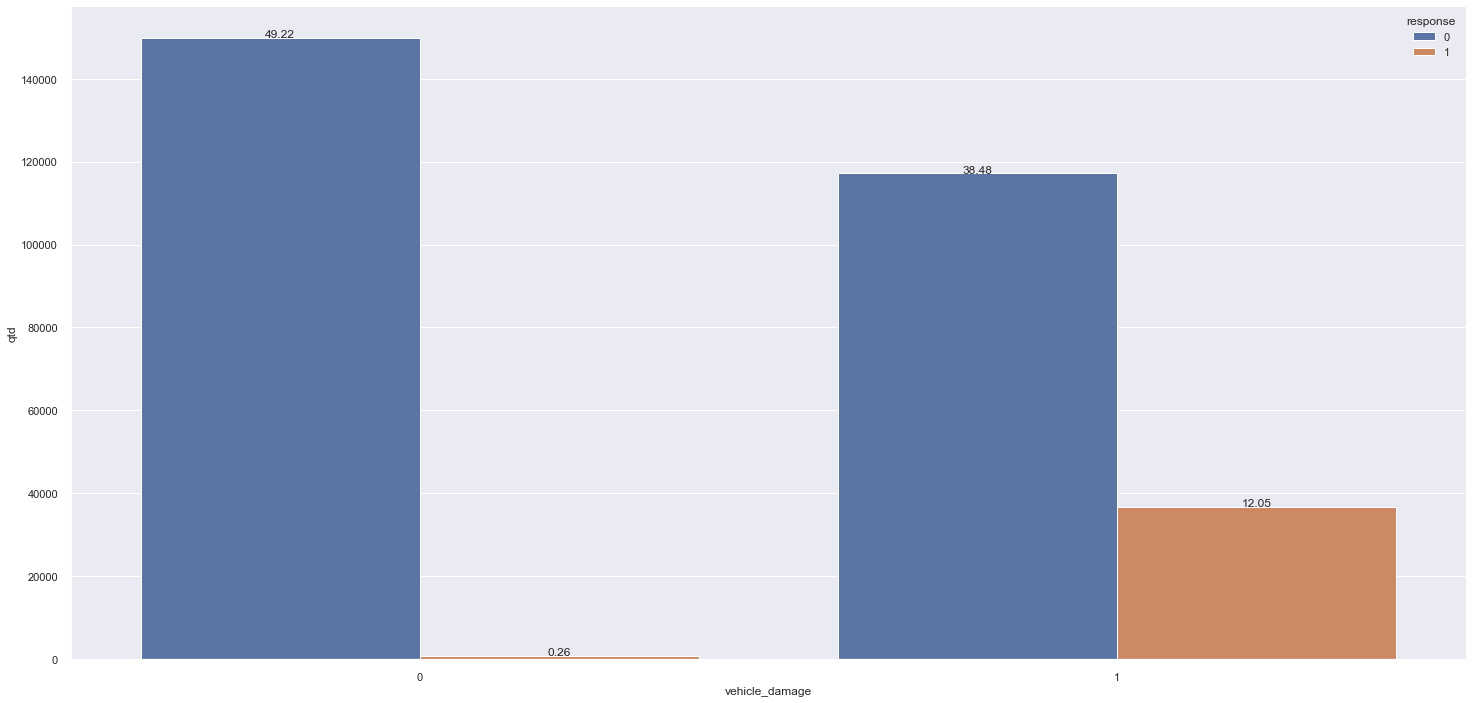

In [62]:
aux=df4[['vehicle_damage','response']].groupby(['vehicle_damage','response']).size().reset_index().rename(columns={0:'qtd'})
ax = sns.barplot(data=aux,x='vehicle_damage',y='qtd',hue='response');
total=sum(aux['qtd'])
graphic_percentage(ax,total)

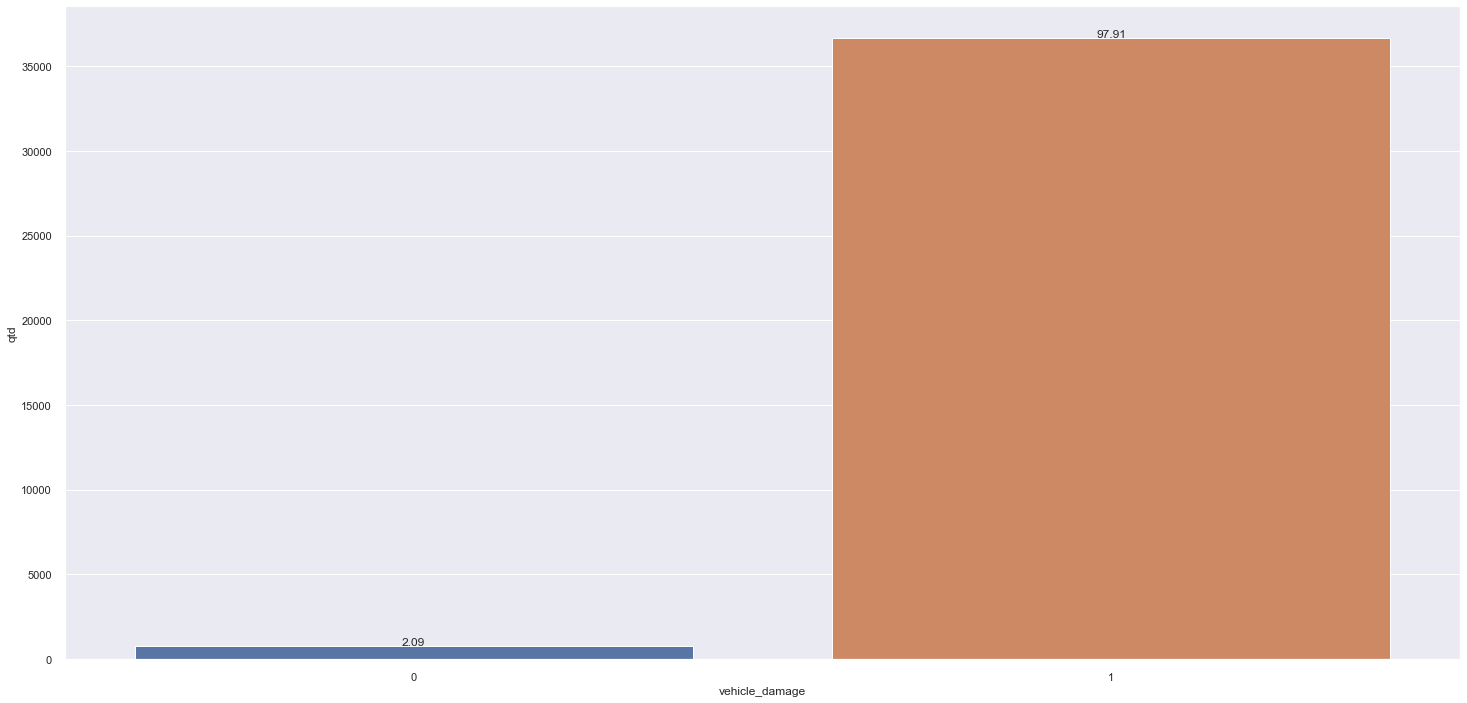

In [63]:
aux=aux[aux['response']==1]
ax = sns.barplot(data=aux,x='vehicle_damage',y='qtd');
total=sum(aux['qtd'])

graphic_percentage(ax,total)

### H3 - Clientes que possuem carros mais novos (até 2 anos de uso), tem mais interesse em comprar o seguro de carro
**Verdadeira** - De um total de 37485 interessados em adquirir o seguro de carro, 89.9% possuem carros mais novos (até 2 anos de uso)

In [64]:
df4[['id','vehicle_age', 'response']].groupby( ['vehicle_age', 'response'] ).count().reset_index()

,vehicle_age,response,id
0,below_1_year,0,125991
1,below_1_year,1,5791
2,between_1_2_year,0,132222
3,between_1_2_year,1,27945
4,over_2_years,0,8995
5,over_2_years,1,3749


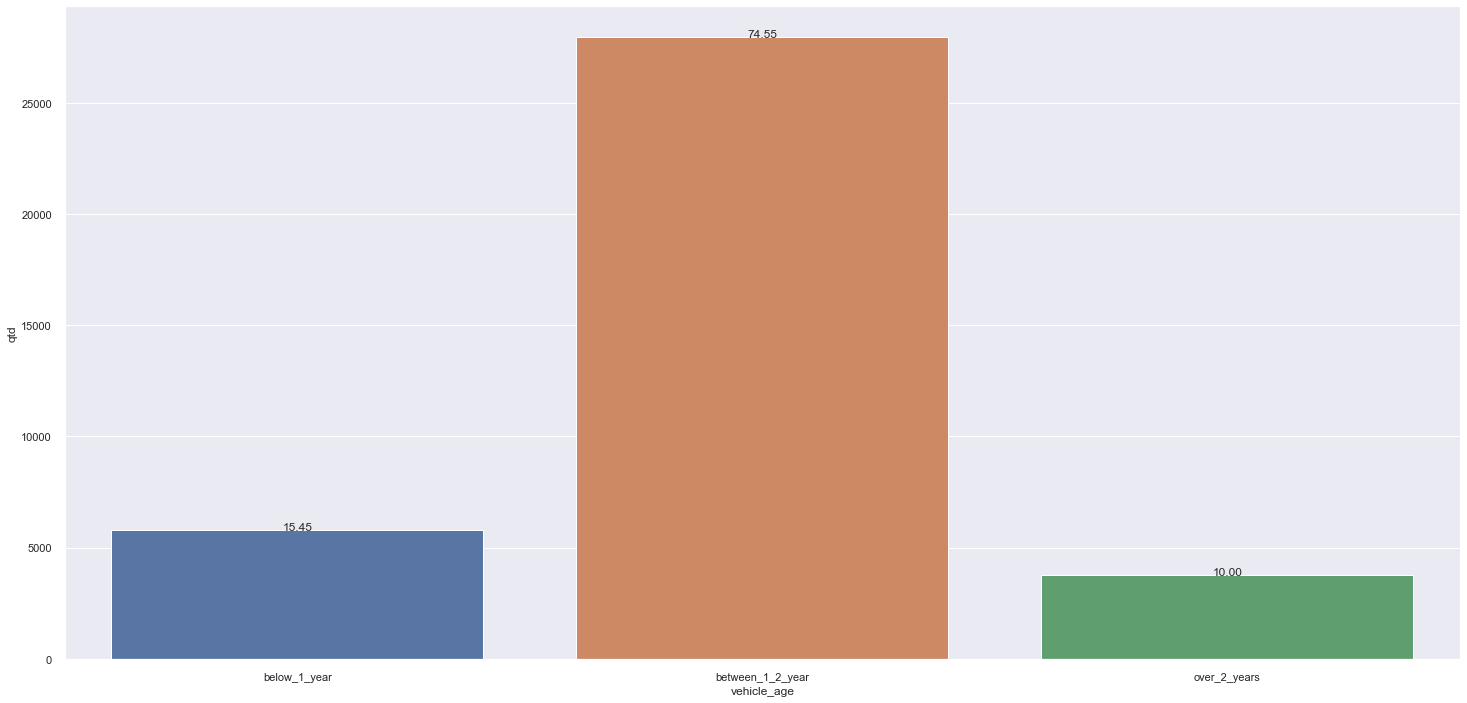

In [65]:
aux=df4[df4['response']==1]
aux=aux[['vehicle_age']].groupby('vehicle_age').size().reset_index().rename(columns={0:'qtd'})
ax=sns.barplot(data=aux,x='vehicle_age',y='qtd');
total=sum(aux['qtd'])
graphic_percentage(ax,total)

### H4 - Apenas as pessoas que possuem carteira de motorista tem interesse em seguro de carro
**Falsa** - Apesar de ser em uma pequena proporção, não é possível afirmar que todas as pessoas que não tem carteira de motorista também não querem o seguro de carro. 

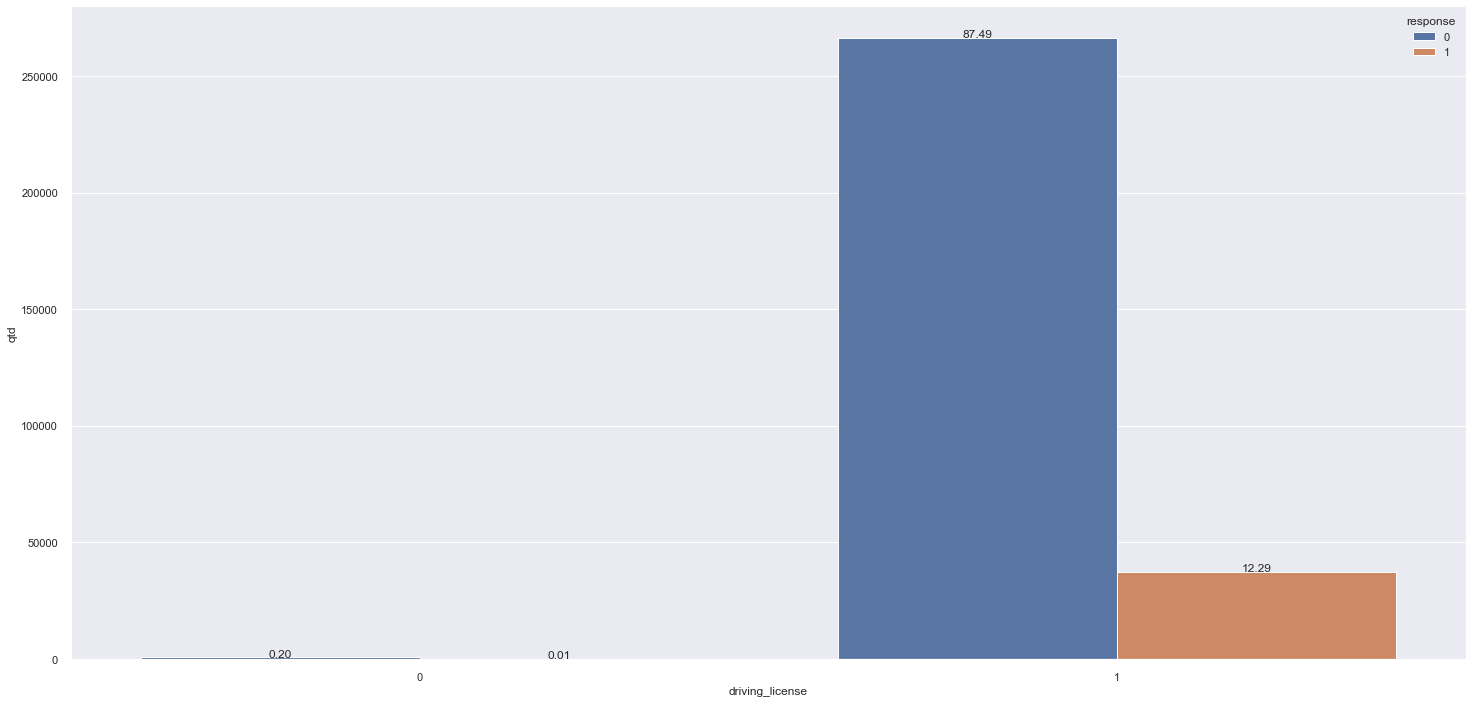

In [66]:
aux=df4[['driving_license','response']].groupby(['driving_license','response']).size().reset_index().rename(columns={0:'qtd'})
ax=sns.barplot(data=aux,x='driving_license',y='qtd',hue='response');
total=sum(aux['qtd'])
graphic_percentage(ax,total)

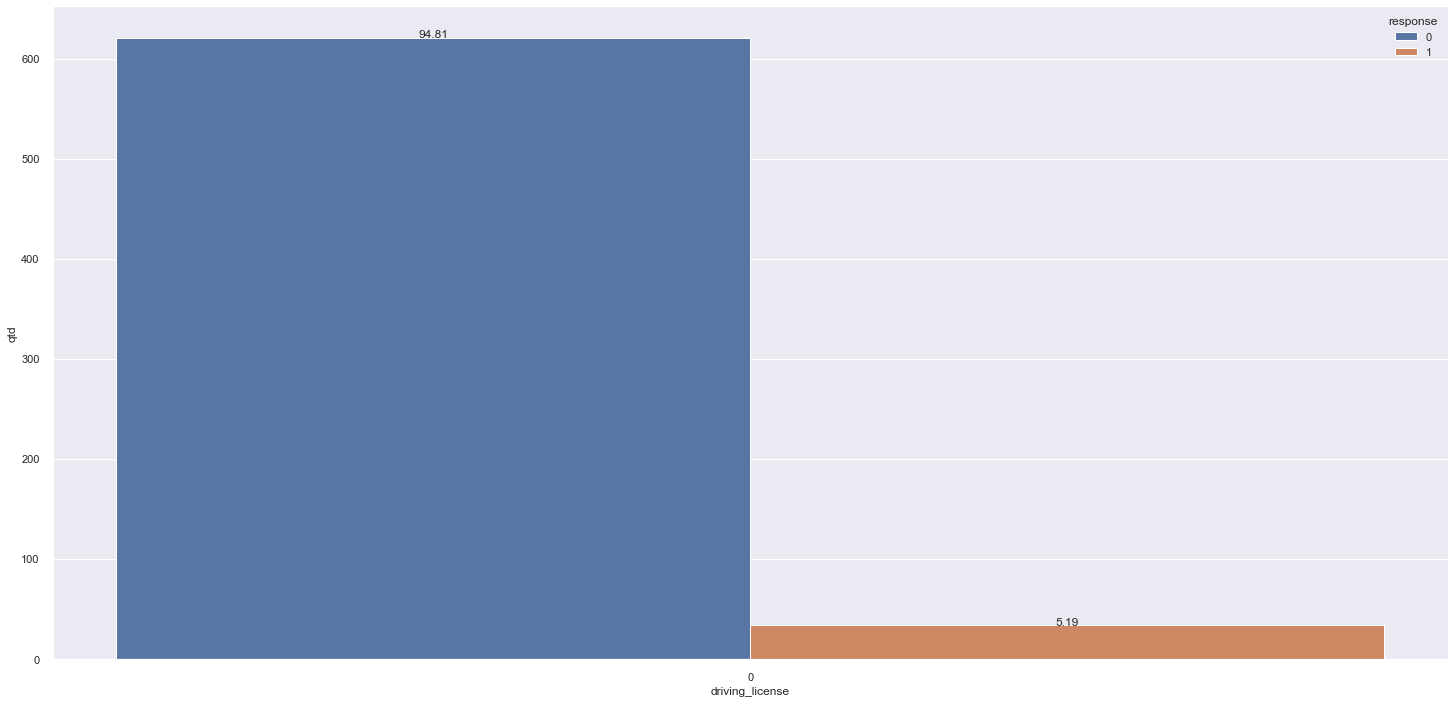

In [67]:
# Analisando separadamente as pessoas que não possuem carteira de motorista (pequena proporção)
aux=aux[aux['driving_license']==0]
ax=sns.barplot(data=aux,x='driving_license',y='qtd',hue='response');
total=sum(aux['qtd'])
graphic_percentage(ax,total)

### H5 - A idade do cliente influencia o interesse em seguro de carro 
**Verdadeira** - É possível observar que existe uma faixa de maior interesse, em adquirir o seguro, de carro de 30 a 60 anos. 

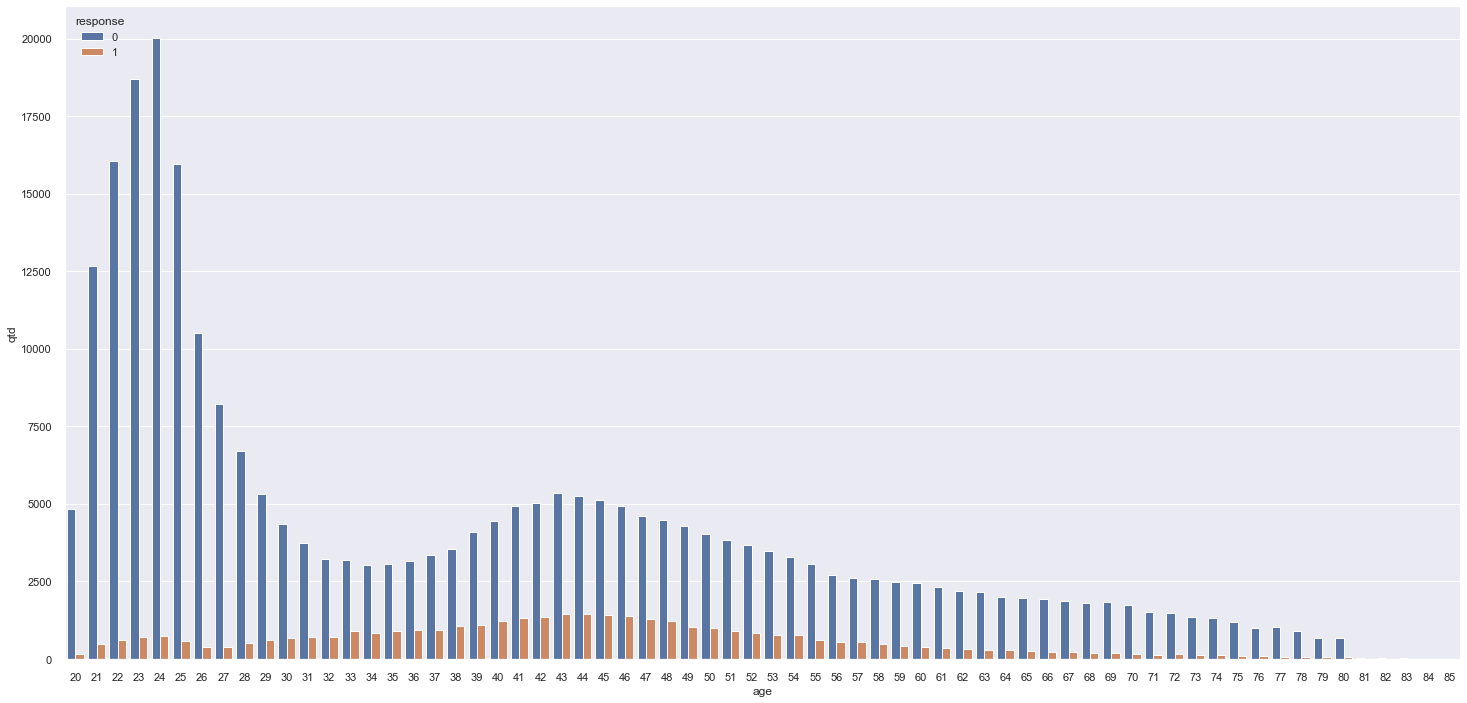

In [69]:
aux=df4[['age','response']].groupby(['age','response']).size().reset_index().rename(columns={0:'qtd'})
sns.barplot(data=aux,x='age',y='qtd',hue='response')

### H6 - Clientes com gastos anuais de seguro-saúde até 40.000, tem maior interesse em adquirir o seguro de carro
**Verdadeira** - Os clientes que tem o gasto anual de até 40.000 e que tem interesse no seguro de veículo, representam 8.79% da base total. E, representam 71.69% dos interessados.

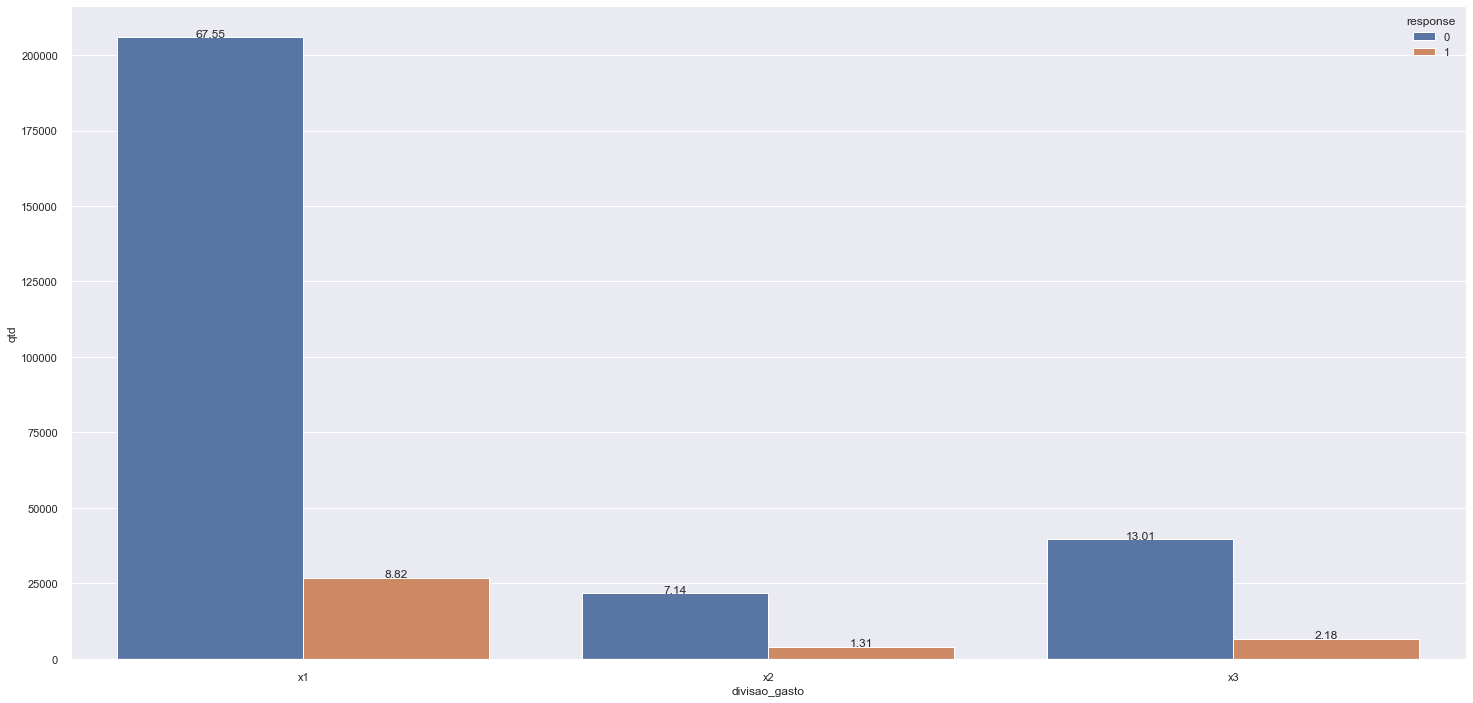

In [70]:
aux = df4.copy()
aux['divisao_gasto'] =aux['annual_premium'].apply(lambda x: 'x1' if x<40000 else 'x2' if x>50000 else 'x3')
aux=aux[['divisao_gasto','response']].groupby(['divisao_gasto','response']).size().reset_index().rename(columns={0:'qtd'})
ax=sns.barplot(data=aux,x='divisao_gasto',y='qtd',hue='response');
total=sum(aux['qtd'])
graphic_percentage(ax,total)

# Sendo os gastos anuais com seguro de saúde: x1=menor que 40.000, x2= entre 40.000  e 50.000 e x3=maior que 50.000

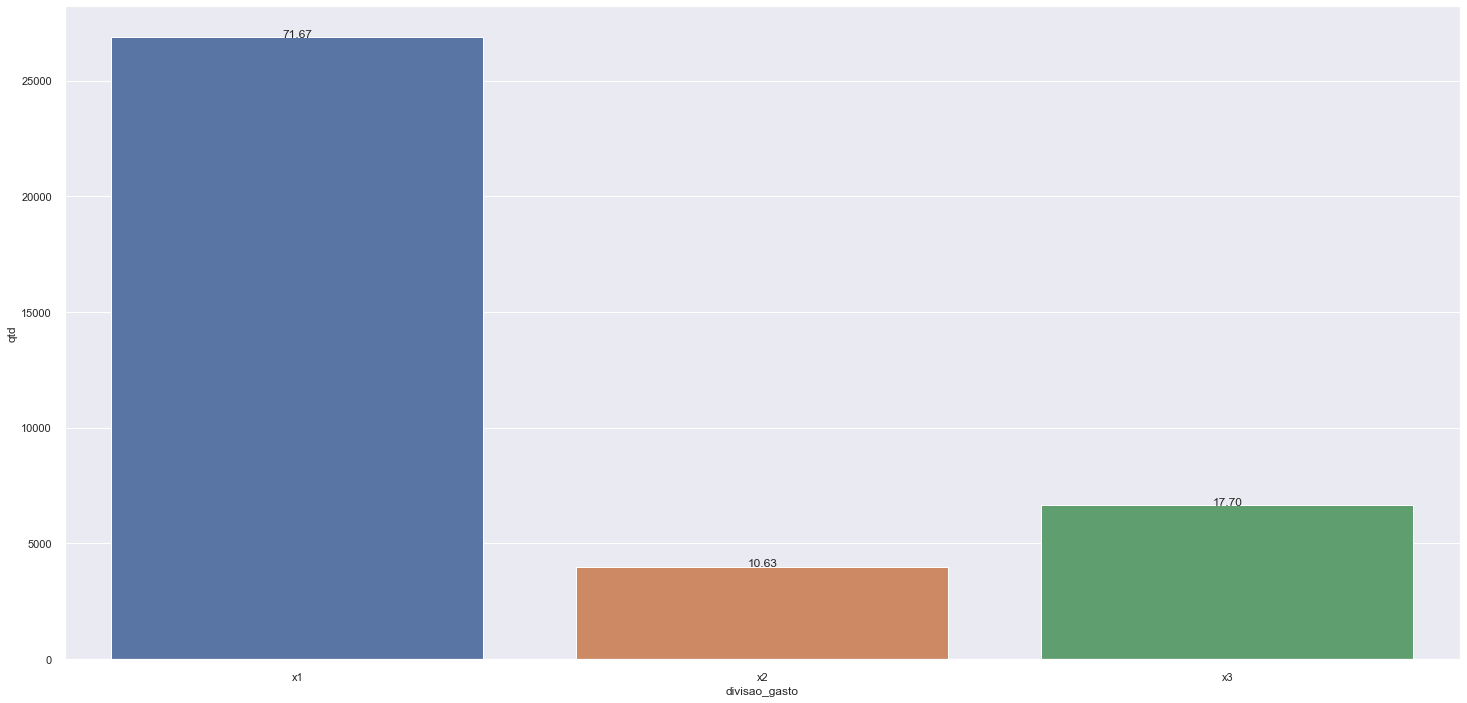

In [71]:
aux=aux[aux['response']==1]
ax=sns.barplot(data=aux,x='divisao_gasto',y='qtd');
total=sum(aux['qtd'])
graphic_percentage(ax,total)

### H7 - Os homens tem a maioria dos eventos de danos aos veículos
***Verdadeira*** - O homens representam 58.54% da base de danos causados aos veículos 

In [72]:
 pd.crosstab( df4['gender'], df4['vehicle_damage'] )

vehicle_damage,0,1
gender,,
Female,76121,63803
Male,74638,90131


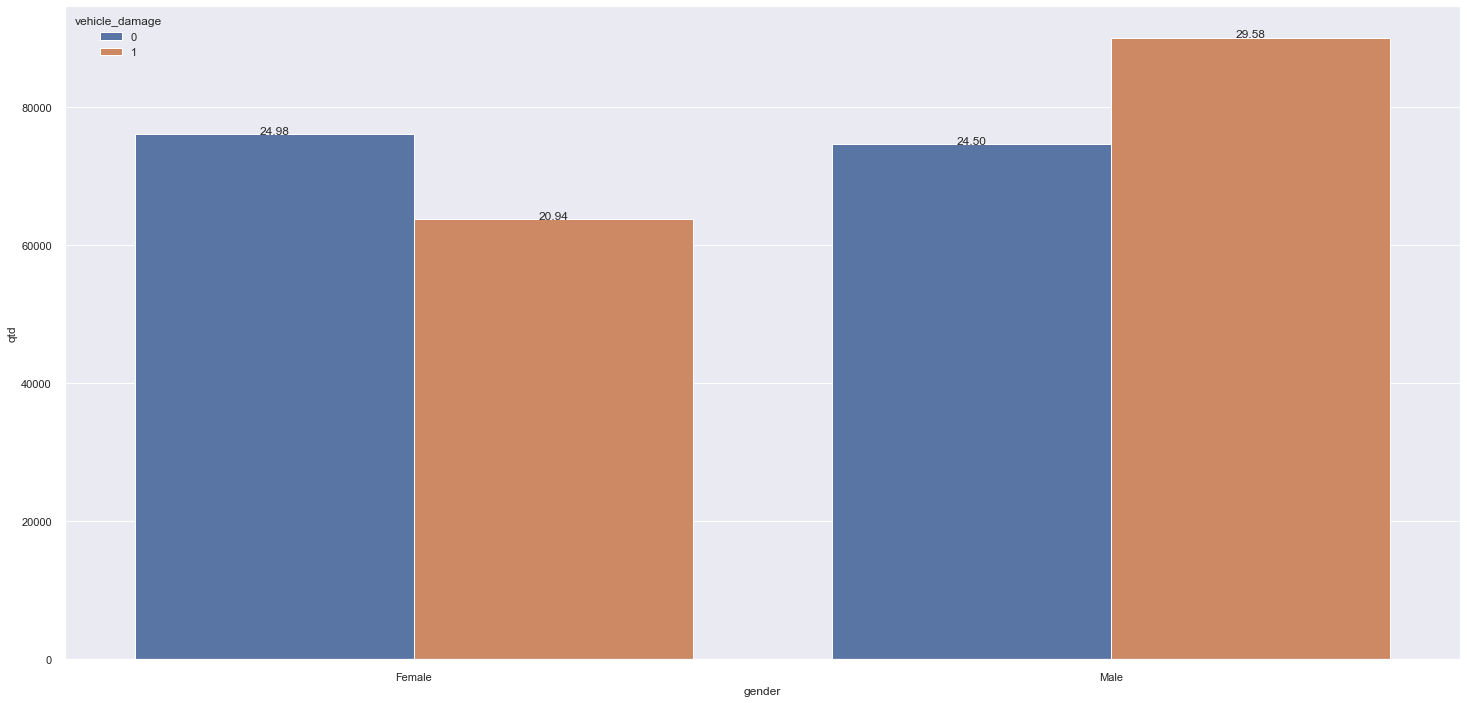

In [73]:
aux=df4[['vehicle_damage','gender']].groupby(['vehicle_damage','gender']).size().reset_index().rename(columns={0:'qtd'})
ax=sns.barplot(data=aux,x='gender',y='qtd',hue='vehicle_damage');
total=sum(aux['qtd'])
graphic_percentage(ax,total)

### 4.2.1 Summary of Hypotheses

In [74]:
tab =[['Hipoteses', 'Conclusao', 'Relevancia'],
      ['H1', 'Verdadeira', 'Alta'],  
      ['H2', 'Verdadeira', 'Alta'],  
      ['H3', 'Verdadeira', 'Alta'],
      ['H4', 'Falsa', 'Baixa'],
      ['H5', 'Verdadeira', 'Média'],
      ['H6', 'Verdadeira', 'Média'],
      ['H7', 'Verdadeira', 'Baixa'],
     ]  
print( tabulate( tab, headers='firstrow' ) )

Hipoteses    Conclusao    Relevancia
-----------  -----------  ------------
H1           Verdadeira   Alta
H2           Verdadeira   Alta
H3           Verdadeira   Alta
H4           Falsa        Baixa
H5           Verdadeira   Média
H6           Verdadeira   Média
H7           Verdadeira   Baixa


## 4.3 Multivariate Analysis

### 4.3.1 Numerical Attributes

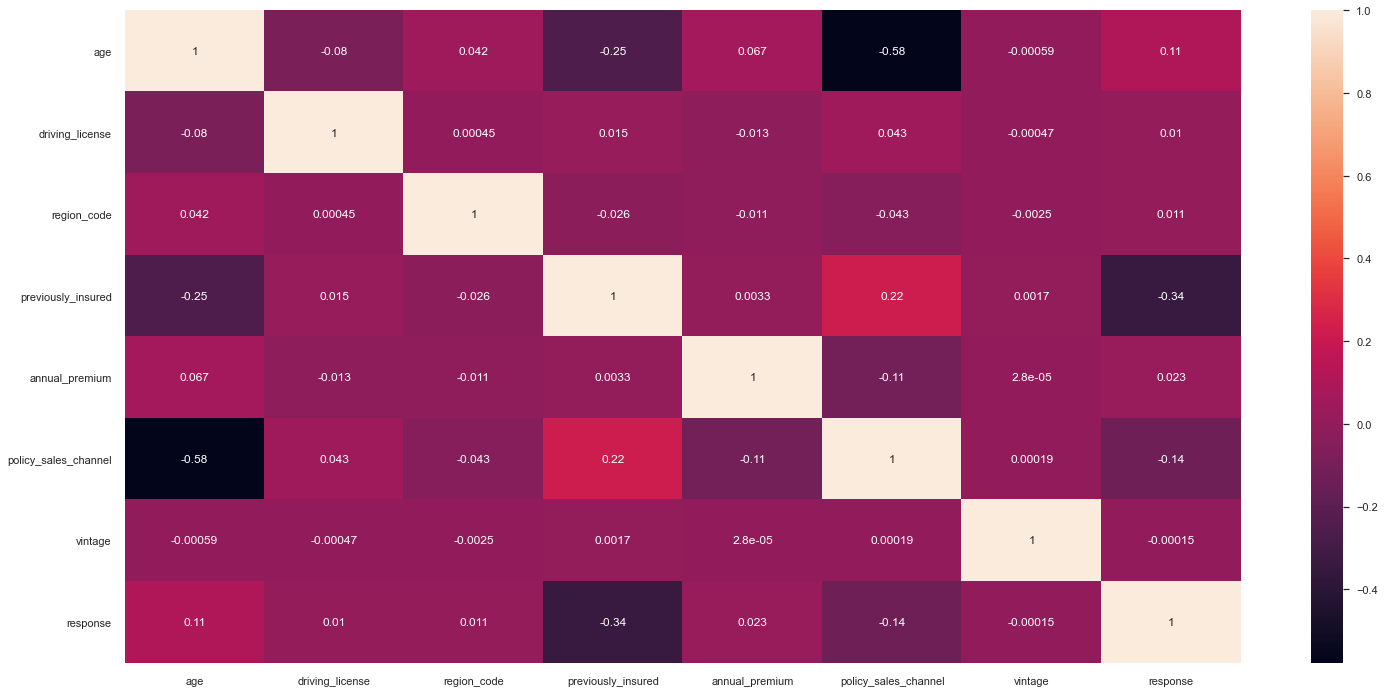

In [75]:
aux= num_attributes.corr()
sns.heatmap(aux,annot=True);

### 4.3.1 Categorical Attributes

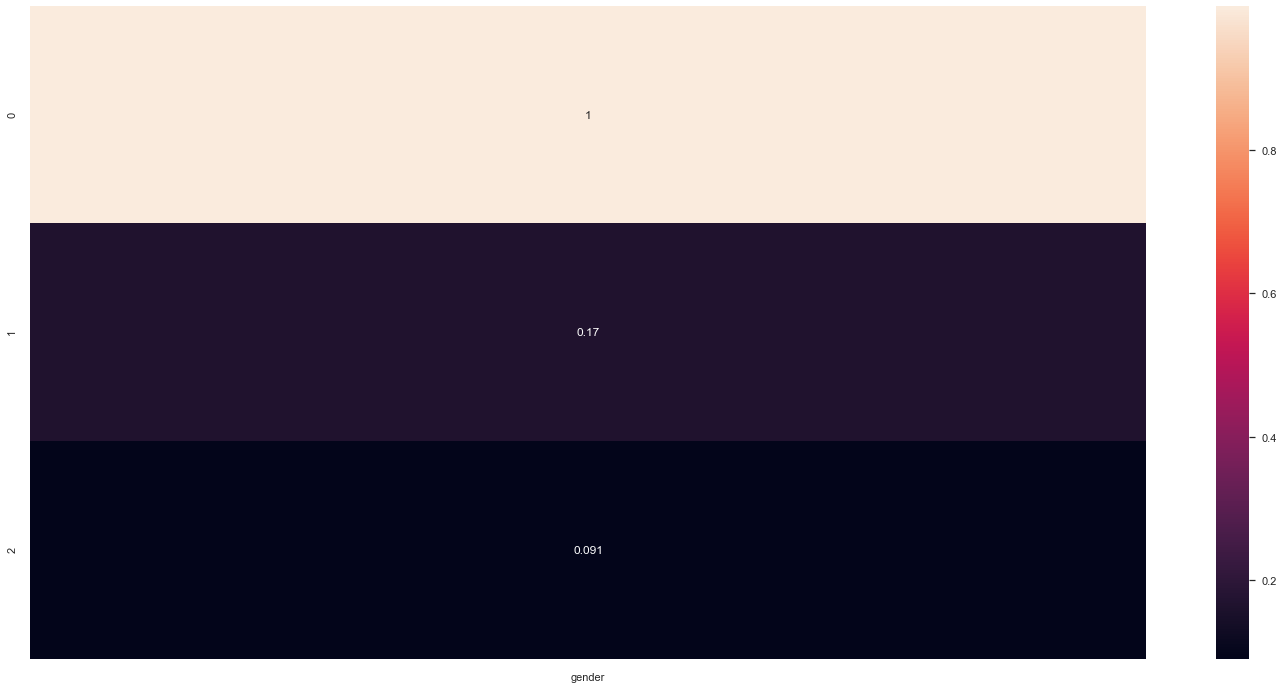

In [76]:
aux=pd.DataFrame(corr_cramer_v(cat_attributes))
sns.heatmap(aux,annot=True);

## 5.0 Data preparation

## 5.1  Standardization

In [77]:
import sklearn.model_selection as ms

In [78]:
ss = pp.StandardScaler()
# anual premium - StandarScaler
df4['annual_premium'] = ss.fit_transform( df4[['annual_premium']].values )
pickle.dump( ss, open( 'C:/Repos/pa004/annual_premium_scaler2.pkl', 'wb' ) )

## 5.2 Rescaling

In [80]:
mms_age = pp.MinMaxScaler()
mms_vintage = pp.MinMaxScaler()

# Age - MinMaxScaler
df4['age'] = mms_age.fit_transform( df4[['age']].values )
pickle.dump( mms_age, open( 'C:/Repos/pa004/age_scaler2.pkl', 'wb' ) )

## 5.3 Transformation

In [82]:
# One hot encoding
# gender 
target_encode_gender = df4.groupby( 'gender' )['response'].mean()
df4.loc[:, 'gender'] = df4['gender'].map( target_encode_gender )
pickle.dump( target_encode_gender, open( 'C:/Repos/pa004/target_encode_gender_scaler2.pkl', 'wb' ) )

## Targe encoding
# region code
target_encode_region_code = df4.groupby( 'region_code' )['response'].mean()
df4.loc[:, 'region_code'] = df4['region_code'].map( target_encode_region_code )
pickle.dump(target_encode_region_code, open( 'C:/Repos/pa004/target_encode_region_scaler2.pkl', 'wb' ) )

# vintage 
target_encode_vintage = df4.groupby( 'vintage' )['response'].mean()
df4.loc[:, 'vintage'] = df4['vintage'].map( target_encode_vintage )
pickle.dump( target_encode_vintage, open( 'C:/Repos/pa004/target_encode_vintage_scaler2.pkl', 'wb' ) )

# policy sales channel
target_encode_policy_sales_channel = df4.groupby( 'policy_sales_channel' )['response'].mean()
df4.loc[:, 'policy_sales_channel'] = df4['policy_sales_channel'].map( target_encode_policy_sales_channel )
pickle.dump(target_encode_policy_sales_channel, open( 'C:/Repos/pa004/target_encode_policy_sales_channel_scaler2.pkl', 'wb' ) )

# vehicle_age 
df4 = pd.get_dummies( df4, prefix='vehicle_age', columns=['vehicle_age'] )
pickle.dump( target_encode_gender, open( 'C:/Repos/pa004/vehicle_age2.pkl', 'wb' ) )

In [83]:
df4.head()

,id,gender,age,driving_license,region_code,previously_insured,vehicle_damage,annual_premium,policy_sales_channel,vintage,response,vehicle_age_below_1_year,vehicle_age_between_1_2_year,vehicle_age_over_2_years
0,1,0.139067,0.369231,1,0.187862,0,1,0.574249,0.199912,0.119231,1,0,0,1
1,2,0.139067,0.861538,1,0.129496,0,0,0.172011,0.199912,0.136364,0,0,1,0
2,3,0.139067,0.415385,1,0.187862,0,1,0.448658,0.199912,0.114004,1,0,0,1
6,7,0.139067,0.046154,1,0.114958,0,1,-0.419253,0.028382,0.121951,0,1,0,0
8,9,0.104135,0.061538,1,0.129496,1,0,-0.172026,0.028382,0.108987,0,1,0,0


## 5.4 Split Dataset


In [84]:
df4.drop(columns = ['id'], inplace = True)

columns_order = ['gender', 
                 'age', 
                 'driving_license', 
                 'previously_insured',
                 'vehicle_damage', 
                 'annual_premium', 
                 'vintage',
                 'vehicle_age_below_1_year',
                 'vehicle_age_between_1_2_year',
                 'vehicle_age_over_2_years',
                 'region_code',
                 'policy_sales_channel', 
                 'response']

# mantendo a resposta como a última coluna para melhor fatiamento
df4 = df4.reindex(columns = columns_order)

### 5.4.1 Training and validation Data

In [87]:
msk = np.random.rand(len(df4)) < 0.80
train = df4[msk]
validation = df4[~msk]

x_train = train.iloc[:, :-1]
y_train = train.iloc[:, -1:]

x_validation = validation.iloc[:, :-1]
y_validation = validation.iloc[:, -1:]

### 5.4.2 Target Variable Resampling: Smote + Tomek links

## 5.5 Target Variable Resampling

In [88]:
#  Variável resposta antes do balanceamento
print('Before ressampling')
y_train.value_counts()

Before ressampling


response
0           213863
1            30095
dtype: int64

In [89]:
# Balanceamento
x_train_res, y_train_res = SMOTETomek(random_state = 42).fit_resample(x_train, y_train)

In [90]:
# Depois do balanceamento
print('After ressampling')
y_train_res.value_counts()

After ressampling


response
0           209838
1           209838
dtype: int64

## 6.0 Feature selection

## 6.1 Feature analysis

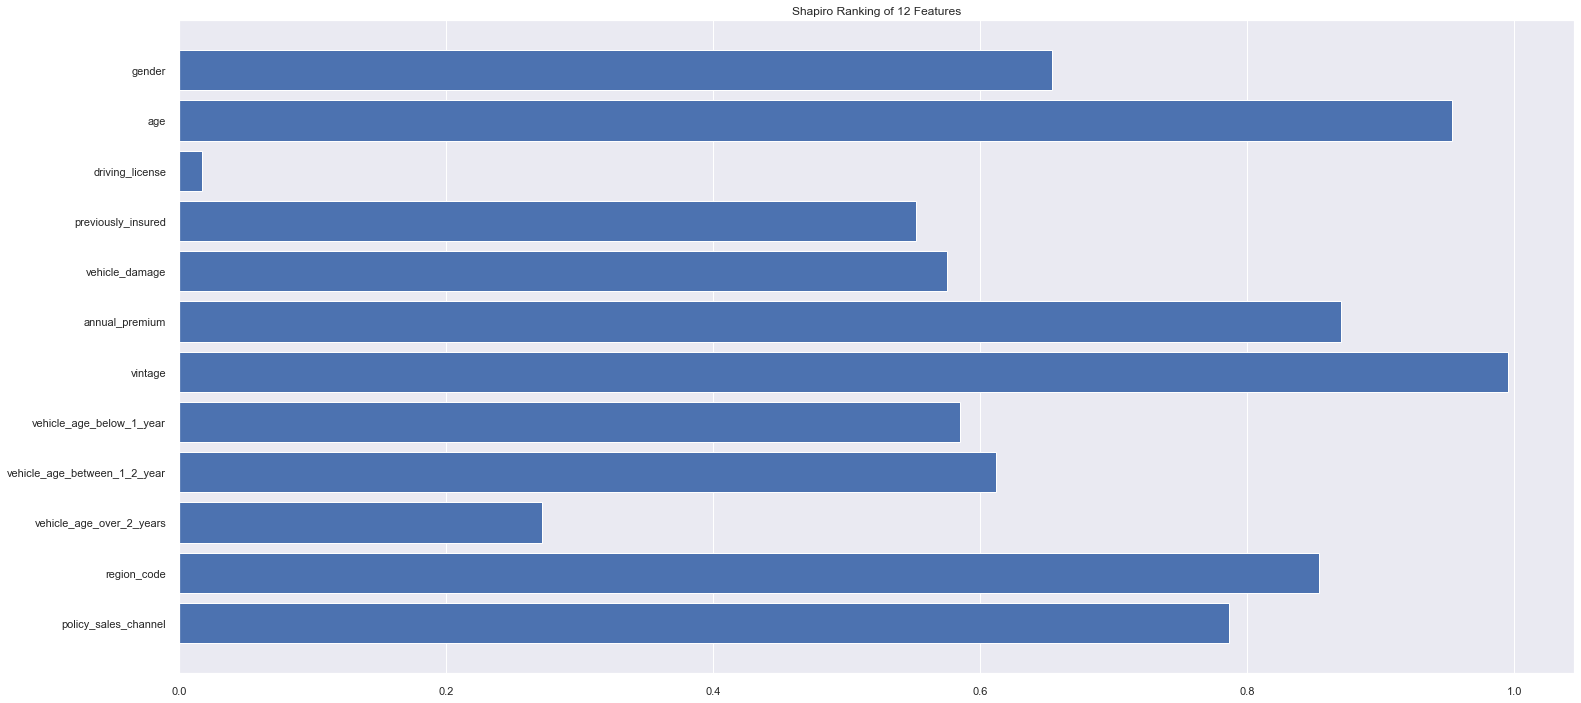

In [91]:
visualizer = Rank1D(algorithm='shapiro')

visualizer.fit(x_train_res, y_train_res)           
visualizer.transform(x_train_res)        
visualizer.show(); 

## 6.2  Feature importance

In [92]:
# model definition
forest = en.ExtraTreesClassifier( n_estimators=250, random_state=0, n_jobs=-1 )

# data preparation
x_train_n = x_train
y_train_n = y_train.values.ravel()
forest.fit( x_train_n, y_train_n )

ExtraTreesClassifier(n_estimators=250, n_jobs=-1, random_state=0)

Feature ranking:
                        feature  importance
0                       vintage    0.257768
0                annual_premium    0.233870
0                           age    0.157477
0                   region_code    0.100270
0          policy_sales_channel    0.097185
0                vehicle_damage    0.073589
0            previously_insured    0.050879
0      vehicle_age_below_1_year    0.013664
0  vehicle_age_between_1_2_year    0.006475
0                        gender    0.005411
0      vehicle_age_over_2_years    0.002950
0               driving_license    0.000462


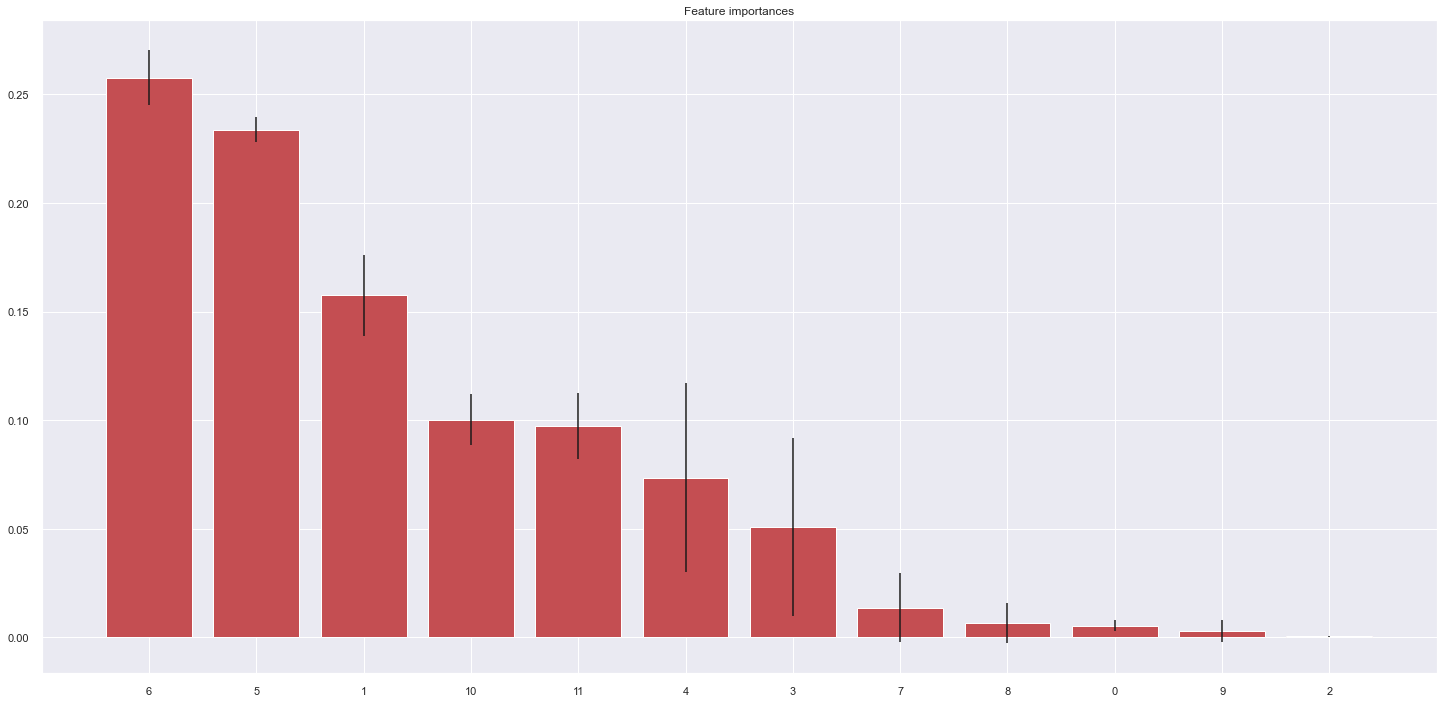

In [93]:
importances = forest.feature_importances_
std = np.std([tree.feature_importances_ for tree in forest.estimators_], axis=0)
indices = np.argsort(importances)[::-1]

# Print the feature ranking
print("Feature ranking:")
df = pd.DataFrame()
for i, j in zip( x_train_n, forest.feature_importances_ ):
    aux = pd.DataFrame( {'feature': i, 'importance': j}, index=[0] )
    df = pd.concat( [df, aux], axis=0 )
    
print( df.sort_values( 'importance', ascending=False ) )

# Plot the impurity-based feature importances of the forest
plt.figure()
plt.title("Feature importances")
plt.bar(range(x_train_n.shape[1]), importances[indices], color="r", yerr=std[indices], align="center")
plt.xticks(range(x_train_n.shape[1]), indices)
plt.xlim([-1, x_train_n.shape[1]])
plt.show()


## 7.0 Machine Learning

In [ ]:
# Métricas a serem utilizadas: métricas de ordenação (curva de ganho acumulada)

In [94]:
cols_selected = ['annual_premium', 'vintage', 'age', 'region_code', 'vehicle_damage', 'previously_insured',
                 'policy_sales_channel']

x_train_res = x_train_res[cols_selected]
x_validation = x_validation[cols_selected]

## 7.1 KNN Classifier

In [95]:
## Procurando o melhor k
Ks = 15

mean_rcc = np.zeros((Ks-1))

for n in range(9,Ks):
    
    #Train Model and Predict  
    knn_model = nh.KNeighborsClassifier(n_neighbors = n).fit(x_train_res,y_train_res.values.ravel())
    yhat = knn_model.predict(x_validation)
    mean_rcc[n-1] = balanced_accuracy_score(y_validation, yhat)

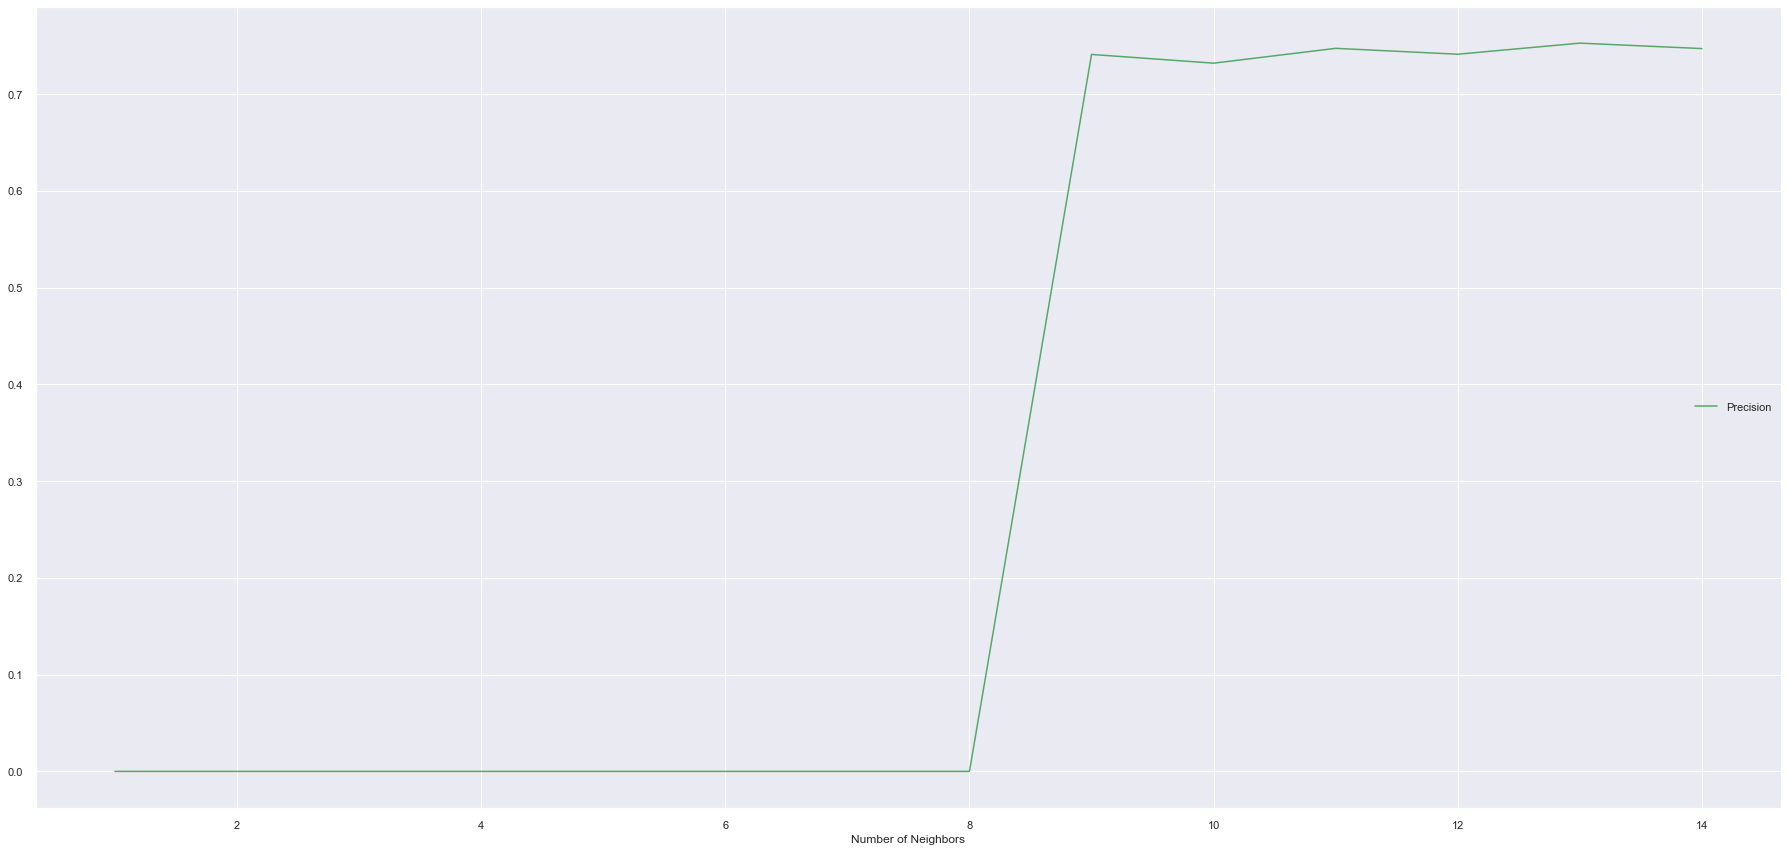

In [96]:
plt.plot(range(1,Ks),mean_rcc,'g')
plt.legend(('Precision', ), loc = 'center right' )
plt.xlabel('Number of Neighbors')
plt.tight_layout()
plt.show()

In [97]:
# Modelo definido com k = 10
model_knn = nh.KNeighborsClassifier( n_neighbors = 10 )

# model training
model_knn.fit( x_train_res, y_train_res.values.ravel() )

# model prediction  
yhat_knn = model_knn.predict( x_validation ) 

#metrics 
print('Balanced Accuracy: '   + str(balanced_accuracy_score(y_validation,yhat_knn)))

Balanced Accuracy: 0.7321088337704205


In [100]:
## Accumulative Gain (curva de ganho acumulada) -> métrica de ordenação
# Passa o y real e o y que o knn encontrou
#skplt.metrics.plot_cumulative_gain(y_val, yhat_knn);

ValueError: Cannot calculate Cumulative Gains for data with 27178 category/ies

In [ ]:
## É possível observar que com 30% da base o algoritmo KNN já acerta em torno de 60% do rankeamento da lista e com 
## 60% da base, já acerta 80% da lista 

In [ ]:
#Scikitplot library is there to help
#skplt.metrics.plot_lift_curve( y_val, yhat_knn );

In [ ]:
#x_val.head()

## 7.2 Logistic Regressor

In [101]:
## Ordenando a lista com regressão logística
# Em 50% da base, consegue identficar todos os clientes da base interessados em seguro 
## (nesse caso a linear regression performou melhor)

lr_model = lm.LogisticRegression( random_state = 42 ) 

# model training
lr_model.fit( x_train_res, y_train_res.values.ravel() )

# model prediction  
yhat_lr = lr_model.predict( x_validation )

# metrics 
print('Balanced Accuracy: '   + str(balanced_accuracy_score(y_validation,yhat_lr)))

Balanced Accuracy: 0.791387895399911


In [ ]:
# Accumulative Gain
#skplt.metrics.plot_cumulative_gain( y_val, yhat_lr );

In [ ]:
#Scikitplot library is there to help
#skplt.metrics.plot_lift_curve( y_val, yhat_lr );

## 7.3 XGBoost Classifier

In [102]:
# model definition
model_xgb = xgb.XGBClassifier(n_estimators = 7, 
                              eta = 0.01, 
                              max_depth = 2, 
                              subsample = 0.7,
                              use_label_encoder = False,
                              eval_metric = 'aucpr',
                              colsample_bytree = 0.9)

#model training
model_xgb.fit( x_train_res, y_train_res.values.ravel() )

# prediction
yhat_xgb = model_xgb.predict( x_validation )

#metrics 
print('Balanced Accuracy: '   + str(balanced_accuracy_score(y_validation,yhat_xgb)))

Balanced Accuracy: 0.767073943948239


## 7.4 Naive Bayes

In [104]:
#model definition
model_nb = GaussianNB()

#train model
model_nb.fit( x_train_res, y_train_res.values.ravel() )

#prediction
yhat_nb = model_nb.predict( x_validation )
yhat_nb_1 = model_nb.predict_proba( x_validation )

#metrics 
print('Balanced Accuracy: '   + str(balanced_accuracy_score(y_validation,yhat_nb)))

Balanced Accuracy: 0.7850882649021338


## 7.5 LGBM

In [105]:
model_lgbm=LGBMClassifier()
#model training
model_lgbm.fit( x_train_res, y_train_res.values.ravel() )

# prediction
yhat_lgbm = model_lgbm.predict( x_validation )

#metrics 
print('Balanced Accuracy: '   + str(balanced_accuracy_score(y_validation,yhat_lgbm)))

Balanced Accuracy: 0.6886327491876036


## 7.6 Random Forest

In [106]:
#model definition
model_rf = RandomForestClassifier(max_depth = 2, random_state = 0)

#train model
model_rf.fit( x_train_res, y_train_res.values.ravel() )

#predict
yhat_rf = model_rf.predict( x_validation )

# metrics 
print('Balanced Accuracy: '   + str(balanced_accuracy_score(y_validation,yhat_rf)))

Balanced Accuracy: 0.7947675603607178


## 8. Model performance

In [107]:
df5=df4.copy()

In [108]:
xgb_val = cross_validation(model_xgb, x_train_res, y_train_res, 5, df5, Verbose = False)
lr_val = cross_validation(lr_model, x_train_res, y_train_res, 5, df5, Verbose = False)
lgbm_val = cross_validation(model_lgbm, x_train_res, y_train_res, 5, df5, Verbose = False)
nb_val = cross_validation(model_nb, x_train_res, y_train_res, 5, df5, Verbose = False)
rf_val = cross_validation(model_rf, x_train_res, y_train_res, 5, df5, Verbose = False)
knn_val= cross_validation(model_knn, x_train_res, y_train_res, 5, df5, Verbose = False)

In [109]:
results = pd.concat([xgb_val,lr_val,lgbm_val,nb_val,rf_val,knn_val])
results.sort_values(by = 'Recall Mean', ascending = False)

,Model Name,Accuracy Mean,Precision Mean,Precision STD,Recall Mean,Recall STD,Precision@K Mean,Precision@K STD,Recall@K Mean,Recall@K STD
0,XGBClassifier,0.7865,0.7068,0.0042,0.9793,0.0004,0.8137,0.0282,0.3878,0.0134
0,GaussianNB,0.7902,0.7108,0.0006,0.9786,0.0005,0.7874,0.0015,0.3753,0.0007
0,KNeighborsClassifier,0.8473,0.7912,0.0014,0.9437,0.0010,0.8982,0.0072,0.4280,0.0034
0,LogisticRegression,0.7975,0.7343,0.0010,0.9324,0.0017,0.7949,0.0023,0.3788,0.0011
0,RandomForestClassifier,0.8022,0.7419,0.0011,0.9267,0.0042,0.8391,0.0010,0.3999,0.0005
0,LGBMClassifier,0.8886,0.8725,0.0024,0.9101,0.0020,0.9997,0.0002,0.4765,0.0001


## 9. Final Model

In [110]:
df5.head()

,gender,age,driving_license,previously_insured,vehicle_damage,annual_premium,vintage,vehicle_age_below_1_year,vehicle_age_between_1_2_year,vehicle_age_over_2_years,region_code,policy_sales_channel,response
0,0.139067,0.369231,1,0,1,0.574249,0.119231,0,0,1,0.187862,0.199912,1
1,0.139067,0.861538,1,0,0,0.172011,0.136364,0,1,0,0.129496,0.199912,0
2,0.139067,0.415385,1,0,1,0.448658,0.114004,0,0,1,0.187862,0.199912,1
6,0.139067,0.046154,1,0,1,-0.419253,0.121951,1,0,0,0.114958,0.028382,0
8,0.104135,0.061538,1,1,0,-0.172026,0.108987,1,0,0,0.129496,0.028382,0


In [111]:
model_lgbm = LGBMClassifier()

#training
lgbm_val = cross_validation(model_lgbm, x_train_res, y_train_res, 10, df5, Verbose = True)

# prediction
yhat_lgbm = model_lgbm.predict_proba( x_validation )

Fold Number 1/10
Fold Number 2/10
Fold Number 3/10
Fold Number 4/10
Fold Number 5/10
Fold Number 6/10
Fold Number 7/10
Fold Number 8/10
Fold Number 9/10
Fold Number 10/10


In [112]:
x_validation.head()

,annual_premium,vintage,age,region_code,vehicle_damage,previously_insured,policy_sales_channel
2,0.448658,0.114004,0.415385,0.187862,1,0,0.199912
12,0.048339,0.118447,0.323077,0.071998,0,1,0.096579
17,0.932880,0.127127,0.076923,0.122534,0,1,0.028382
20,0.616694,0.137105,0.692308,0.187862,1,0,0.189725
26,0.451391,0.137963,0.476923,0.187862,1,0,0.189725


In [120]:
y_validation.head()

,response
2,1
12,0
17,0
20,0
26,1


## 10. Bisness Performance

In [113]:
## Organizando o df data: Adicionando as colunas response (y_validation) e score (predição do modelo: yhat_lgbm)
data = x_validation.copy()

data['response'] = y_validation.copy()
data['score'] = yhat_lgbm[:, 1].tolist()
data = data.sort_values('score', ascending=False)

In [114]:
data.head(25)

,annual_premium,vintage,age,region_code,vehicle_damage,previously_insured,policy_sales_channel,response,score
216457,0.175209,0.135427,0.215385,0.122534,0,1,0.028382,0,0.999997
64823,0.174046,0.133019,0.200000,0.088479,0,1,0.028382,0,0.999997
348125,0.170150,0.135885,0.200000,0.132735,0,1,0.028382,0,0.999996
272187,0.173929,0.133836,0.261538,0.096157,0,1,0.028382,0,0.999996
151677,0.291031,0.130755,0.307692,0.125239,0,1,0.150502,0,0.999025
299684,0.556341,0.130682,0.276923,0.096759,0,1,0.150502,0,0.998461
177813,0.938403,0.122018,0.261538,0.187862,1,0,0.179487,0,0.942349
340166,-0.060855,0.118217,0.215385,0.114958,1,0,0.198630,0,0.939953
78395,-0.280871,0.122927,0.400000,0.187862,1,0,0.177215,0,0.933533
313940,-1.624980,0.121387,0.184615,0.187862,1,0,0.179487,1,0.931700


### 10.1 --- 20.000 calls --- Avaliando a performance das 20.000 ligações listadas pelo modelo 

In [115]:
## Ao utilizar 32,9% dos dados de validação, o que se traduziria em 20 mil atendimentos pela equipe de vendas,
## o modelo seria capaz de identificar 81,8% de pessoas do total de interessados em adquirir o seguro.

percent_of_dataset = 20000 / len(data)
recall_at_20000 = recall_at_k(data, k = 20000)
precision_at_20000=precision_at_k(data,k=20000)

print('Percent of Data: ',percent_of_dataset)
print('Recall at 20000: ',recall_at_20000)
print('Precision at 20000: ',precision_at_20000)

Percent of Data:  0.3292994154935375
Recall at 20000:  0.818809201623816
Precision at 20000:  0.30253487325633716


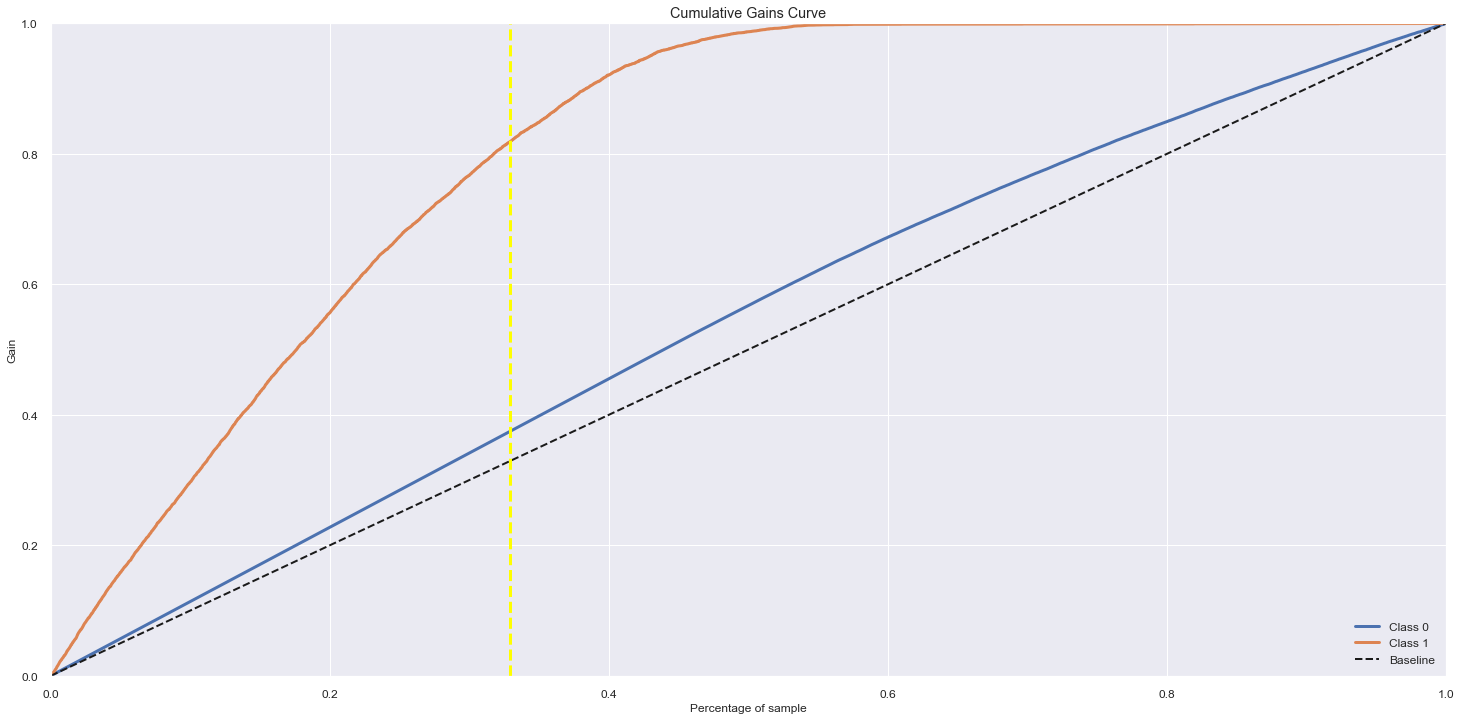

In [116]:
skplt.metrics.plot_cumulative_gain(y_validation, yhat_lgbm)
plt.axvline(percent_of_dataset, 0, 1, color='yellow', ls='--', lw=3)
plt.show();

## Ao fazer 20 mil ligações, o modelo proposto é cerca de 2,5 vezes melhor do que a escolha aleatória.

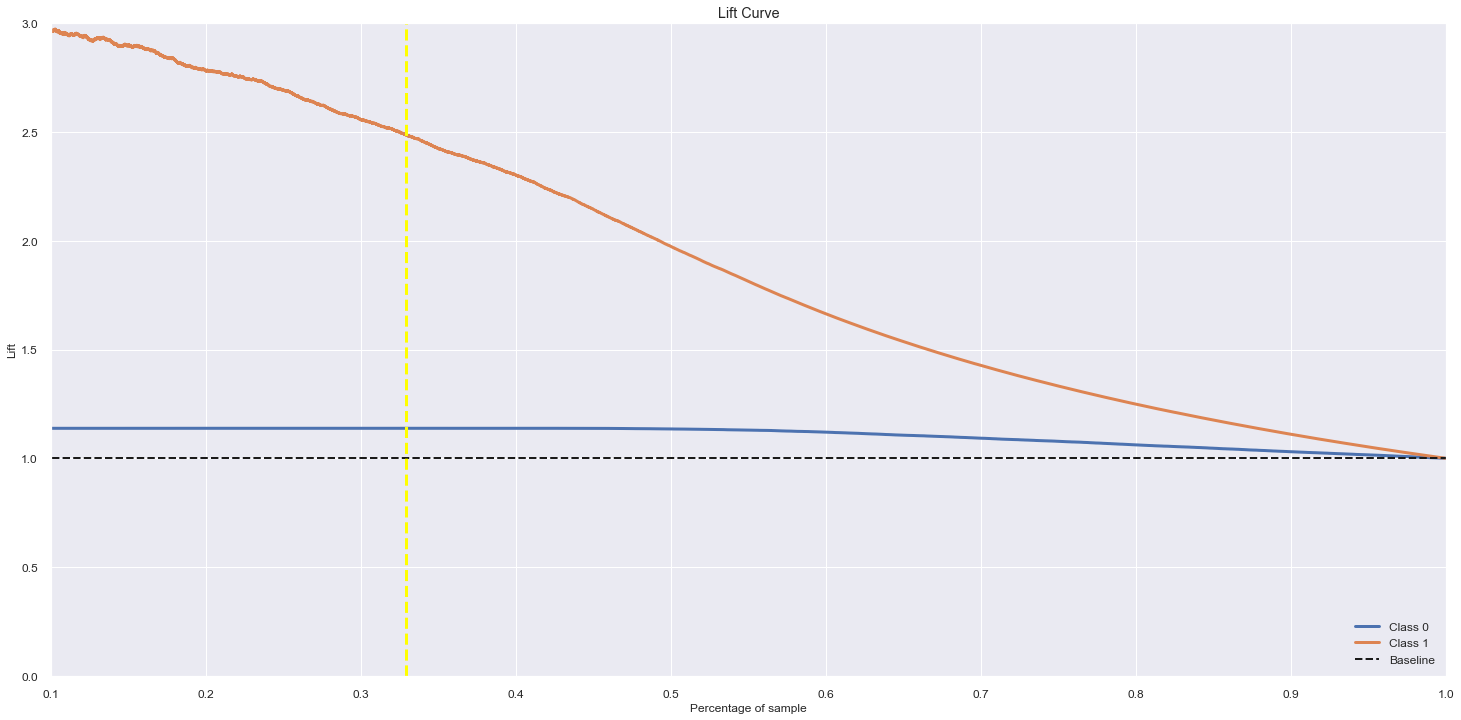

In [121]:
skplt.metrics.plot_lift_curve(y_validation, yhat_lgbm)
plt.axvline(percent_of_dataset, 0, 1, color='yellow', ls='--', lw=3);
plt.xlim(0.1,1);
plt.ylim(0,3);

In [ ]:
### 10.2 --- 40.000 calls --- Avaliando a performance das 40.000 ligações listadas pelo modelo

In [122]:
## Ao utilizar 65,65% dos dados de validação, o que se traduziria em 40 mil ligações realizadas pela equipe de vendas, 
## o modelo seria capaz de identificar 99,9% de pessoas do total de interessados em adquirir o seguro.

percent_of_dataset = 40000 / len(data)
recall_at_40000 = recall_at_k(data, k = 40000)
precision_at_40000=precision_at_k(data,k=40000)

print('Percent of Data: ',percent_of_dataset)
print('Recall at 40000: ',recall_at_40000)
print('Precision at 40000: ',precision_at_40000)

Percent of Data:  0.658598830987075
Recall at 40000:  0.9990527740189445
Precision at 40000:  0.1845703857403565


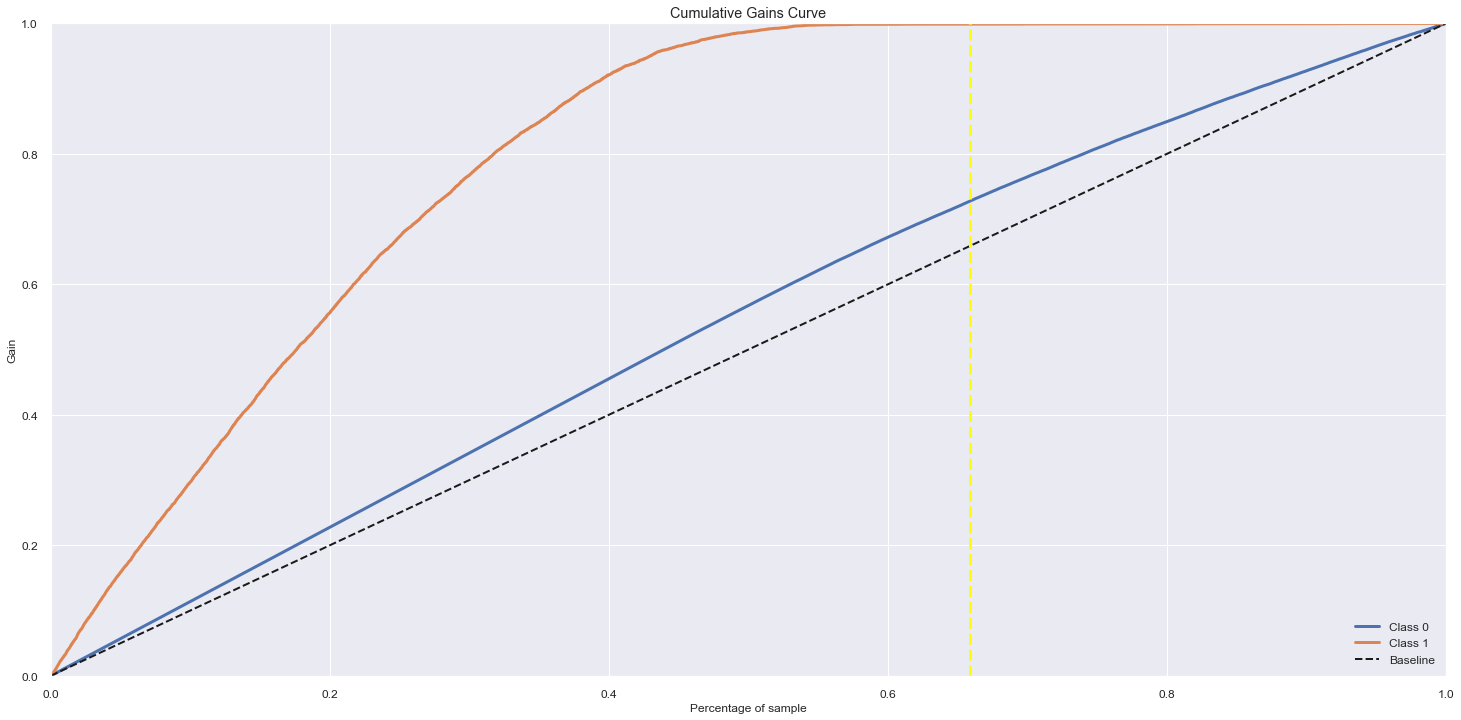

In [123]:
##  Ao fazer 40 mil ligações, o modelo proposto é cerca de 1,6 vezes melhor do que a escolha aleatória.
skplt.metrics.plot_cumulative_gain(y_validation, yhat_lgbm)
plt.axvline(percent_of_dataset, 0, 1, color='yellow', ls='--', lw=3)
plt.show(); 

## 10.3 Business Perfomance on 127.000 New Customers

### 10.3.1 Revenue by making 20.000 Calls (Receita)

In [124]:
random_choice = (33/100) * 127000  # escolha aleatória
model         = (81/100) * 127000  # escolha do modelo

x = random_choice * (2000*12) # renda -> escolha aleatória (anual)
y = model * (2000*12) # renda -> escolha pelo modelo (anual)
dif=y-x

print('{} Annual revenue with random choice'.format(x))
print('{} Annual revenue with model'.format(y))
print('difference in $: {} '.format(dif)  )

1005840000.0 Annual revenue with random choice
2468880000.0 Annual revenue with model
difference in $: 1463040000.0 


### 10.3.2 Revenue by making 40.000 Calls (Receita)

In [125]:
random_choice = (65/100) * 127000
model         = (99/100) * 127000

x = random_choice * (2000*12)
y = model * (2000*12)
dif=y-x

print('{} Annual revenue with random choice'.format(x))
print('{} Annual revenue with model'.format(y))
print('difference in $: {} '.format(dif)  )

1981200000.0 Annual revenue with random choice
3017520000.0 Annual revenue with model
difference in $: 1036320000.0 


### 10.3.3 How many calls to reach 80% of peaple interested? (Quantas ligações para atingir 80% dos interessados)

Digite o número de ligações que deseja realizar: 1000
Percent of Data:  0.016464970774676874
Recall at 1000:  0.05331529093369418
Precision at 1000:  0.3936063936063936


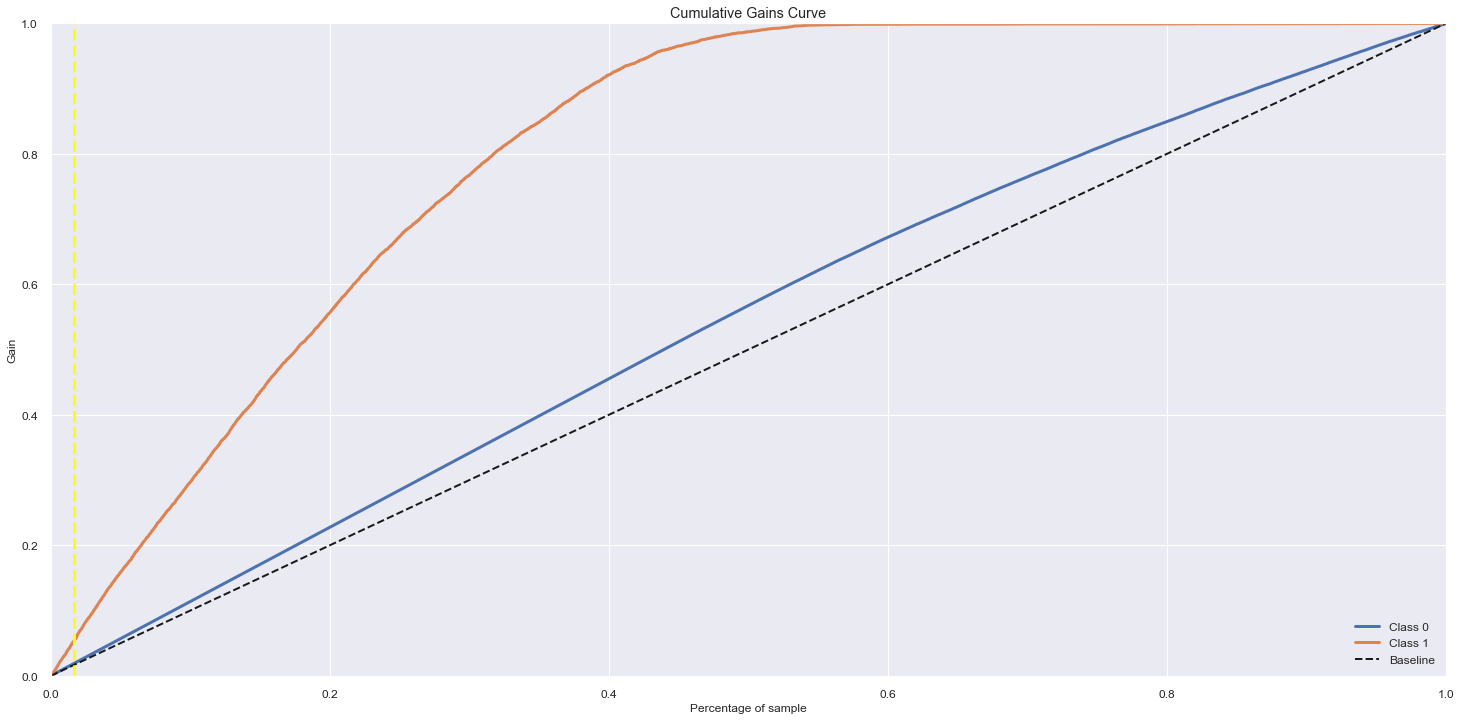

In [128]:
num=input('Digite o número de ligações que deseja realizar: ')
percent_of_dataset = int(num) / len(data)
recall_at_num = recall_at_k(data, k = int(num))
precision_at_num=precision_at_k(data,k=int(num))

print('Percent of Data: ',percent_of_dataset)
print('Recall at {}: '.format(num),recall_at_num)
print('Precision at {}: '.format(num),precision_at_num)

skplt.metrics.plot_cumulative_gain(y_validation, yhat_lgbm)
plt.axvline(percent_of_dataset, 0, 1, color='yellow', ls='--', lw=3)
plt.show();

## 11. Model Generalization Test - Capacidade de generalização do modelo (com dados inéditos) 

In [130]:
df_test= future_test.copy()

In [131]:
df_test.head()

,id,gender,age,driving_license,region_code,previously_insured,vehicle_age,vehicle_damage,annual_premium,policy_sales_channel,vintage,response
3,4,Male,21,1,11.0,1,< 1 Year,No,28619.0,152.0,203,0
4,5,Female,29,1,41.0,1,< 1 Year,No,27496.0,152.0,39,0
5,6,Female,24,1,33.0,0,< 1 Year,Yes,2630.0,160.0,176,0
7,8,Female,56,1,28.0,0,1-2 Year,Yes,32031.0,26.0,72,1
10,11,Female,47,1,35.0,0,1-2 Year,Yes,47576.0,124.0,46,1


In [132]:
# Vehicle Damage Number
df_test['vehicle_damage'] = df_test['vehicle_damage'].apply( lambda x: 1 if x == 'Yes' else 0 )

# Vehicle Age
df_test['vehicle_age'] =  df_test['vehicle_age'].apply( lambda x: 'over_2_years' if x == '> 2 Years' else 'between_1_2_year' if x == '1-2 Year' else 'below_1_year' )

annual_premium_scaler       =   pickle.load( open( 'C:/Repos/pa004/annual_premium_scaler2.pkl','rb' ) )
age_scaler                  =   pickle.load( open( 'C:/Repos/pa004/age_scaler2.pkl','rb' ) ) 
target_encode_vintage_scaler              =   pickle.load( open( 'C:/Repos/pa004/target_encode_vintage_scaler2.pkl','rb' ) ) 
target_encode_gender_scaler =   pickle.load( open( 'C:/Repos/pa004/target_encode_gender_scaler2.pkl','rb' ) )
target_encode_region_scaler =   pickle.load( open( 'C:/Repos/pa004/target_encode_region_scaler2.pkl','rb' ) )
target_encode_policy_sales_channel_scaler =   pickle.load( open( 'C:/Repos/pa004/target_encode_policy_sales_channel_scaler2.pkl','rb' ) )


# anual premium - StandarScaler
df_test['annual_premium'] = annual_premium_scaler.transform( df_test[['annual_premium']].values )


# Age - MinMaxScaler
df_test['age'] = age_scaler.transform( df_test[['age']].values )

# Vintage - Target Encoding
df_test.loc[:, 'vintage'] = df_test['vintage'].map( target_encode_vintage_scaler )

# gender - One Hot Encoding / Target Encoding
df_test.loc[:, 'gender'] = df_test['gender'].map( target_encode_gender_scaler )

# region_code - Target Encoding
df_test.loc[:, 'region_code'] = df_test['region_code'].map( target_encode_region_scaler )


# vehicle_age - One Hot Encoding / Frequency Encoding
df_test = pd.get_dummies( df_test, prefix='vehicle_age', columns=['vehicle_age'] )

# policy_sales_channel - Target Encoding
df_test.loc[:, 'policy_sales_channel'] = df_test['policy_sales_channel'].map( target_encode_policy_sales_channel_scaler )




df_test.drop(columns = ['id'], inplace = True)

columns_order = ['gender', 
                 'age', 
                 'driving_license', 
                 'previously_insured',
                 'vehicle_damage', 
                 'annual_premium', 
                 'vintage',
                 'vehicle_age_below_1_year',
                 'vehicle_age_between_1_2_year',
                 'vehicle_age_over_2_years',
                 'region_code',
                 'policy_sales_channel',
                'response']
            
#keeping response as the last column for better slicing
df_test = df_test.reindex(columns = columns_order)

y_df_test = df_test.iloc[:, -1:]


cols_selected = ['annual_premium', 'vintage', 'age', 'region_code', 'vehicle_damage', 'previously_insured',
                 'policy_sales_channel']

x_df_test = df_test[cols_selected]


In [139]:
## Salvando o modelo treinado
pickle.dump(model_lgbm, open('C:/Repos/pa004/modelo_lgbm.pkl', 'wb'))

In [140]:
## Instanciando o modelo treinado na variável pred
model_lgbm=pickle.load( open( 'C:/Repos/pa004/modelo_lgbm.pkl', 'rb' ) )
pred = model_lgbm.predict_proba( x_df_test )

## 11.1 ---- 20.000 calls ---

Percent of Data:  0.2617252931323283
Recall at 20000:  0.5394037940379404
Precision at 20000:  0.2487875606219689


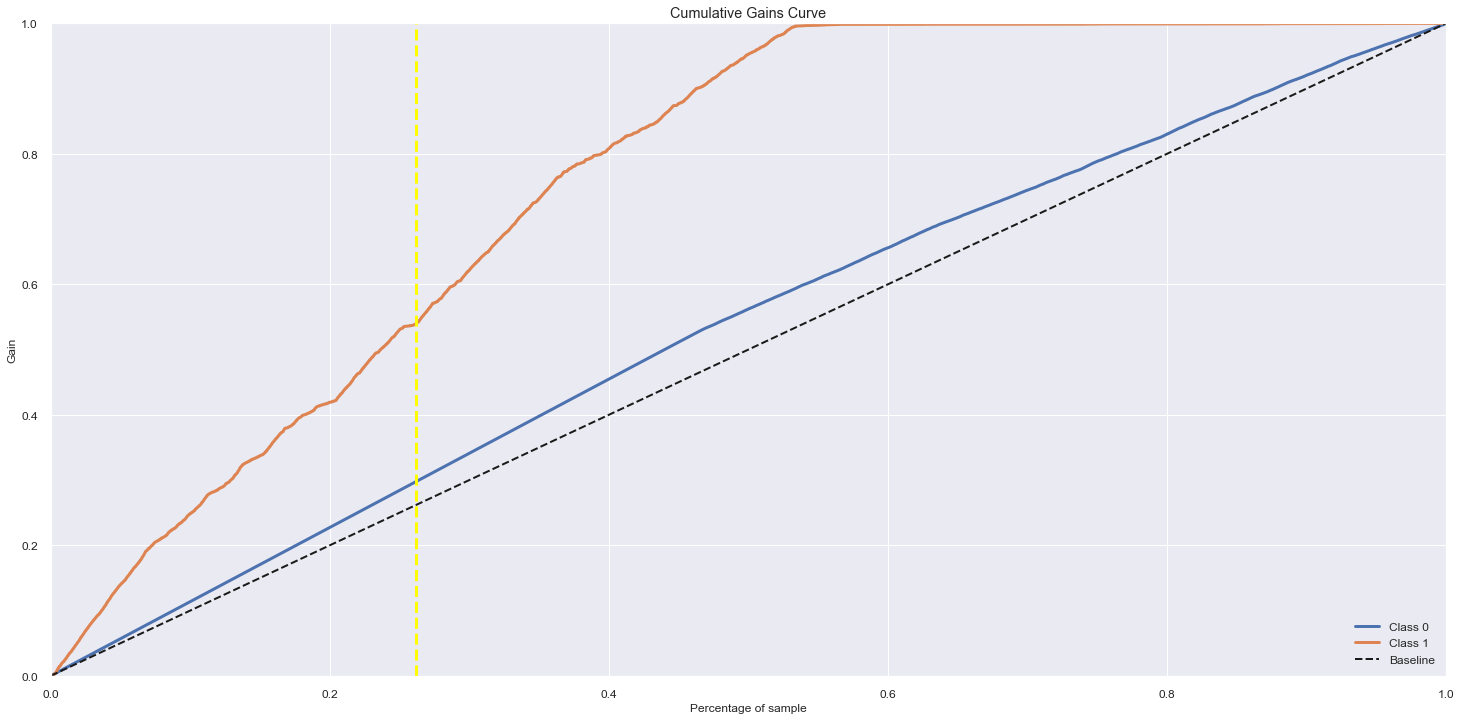

In [141]:
### Considerando 20.000 ligações para clientes: Em 26% da base, o modelo acerta em 55%, isso significa que o modelo acerta em 2.2 vezes mais que a escolha aleatória
## Considerando que são dados inéditos, o modelo está generalizando bem
data = x_df_test.copy()

data['response'] = y_df_test.copy()
data['score'] = pred[:, 1].tolist()
data = data.sort_values('score', ascending=False)

percent_of_dataset = 20000 / len(data)
recall_at_20000 = recall_at_k(data, k = 20000)
precision_at_20000=precision_at_k(data,k=20000)
print('Percent of Data: ',percent_of_dataset)
print('Recall at 20000: ',recall_at_20000)
print('Precision at 20000: ',precision_at_20000)

#skplt.metrics.plot_cumulative_gain(y_test, yhat_nb)
skplt.metrics.plot_cumulative_gain(y_df_test, pred)
plt.axvline(percent_of_dataset, 0, 1, color='yellow', ls='--', lw=3)
plt.show();

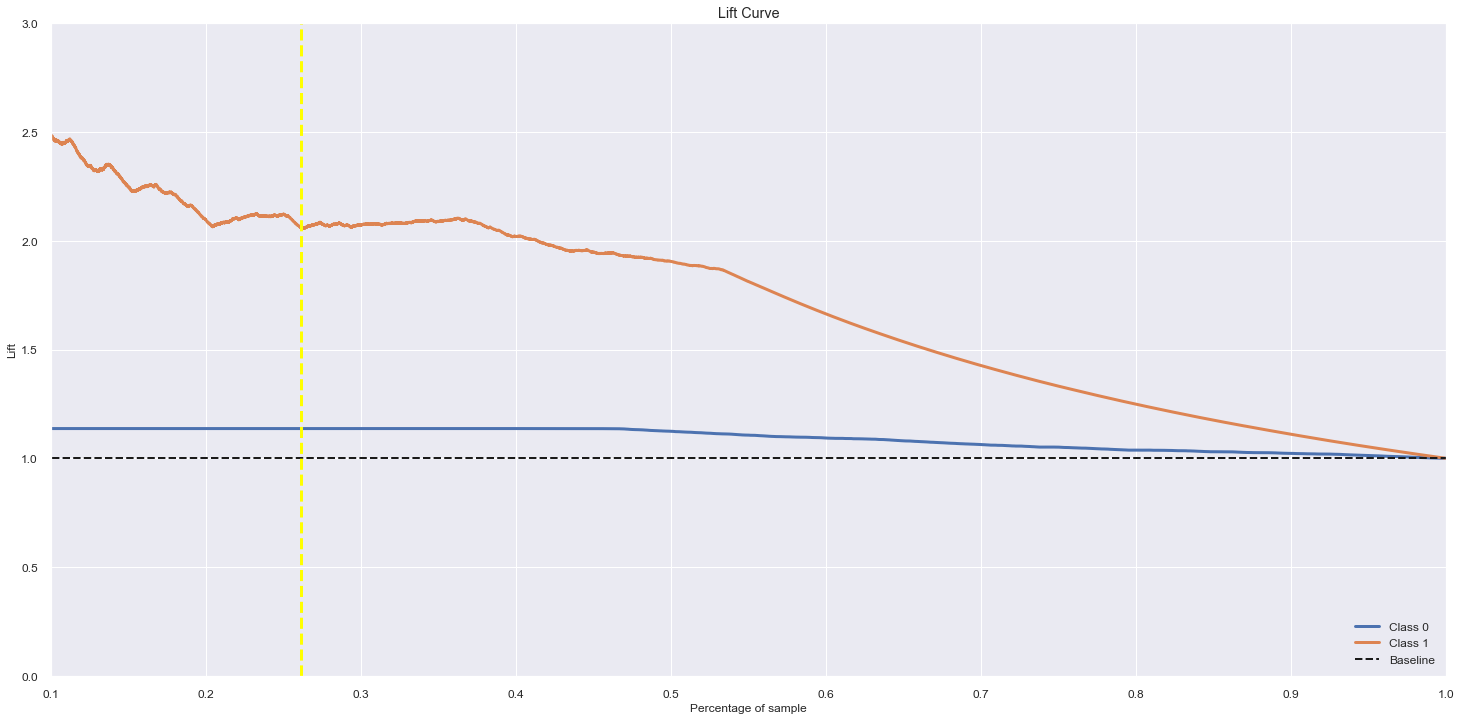

In [142]:
skplt.metrics.plot_lift_curve(y_df_test, pred)
plt.axvline(percent_of_dataset, 0, 1, color='yellow', ls='--', lw=3);
plt.xlim(0.1,1);
plt.ylim(0,3);

## 11.2 ---- 40.000 calls ---

Percent of Data:  0.5234505862646566
Recall at 40000:  0.9822222222222222
Precision at 40000:  0.2265193370165746


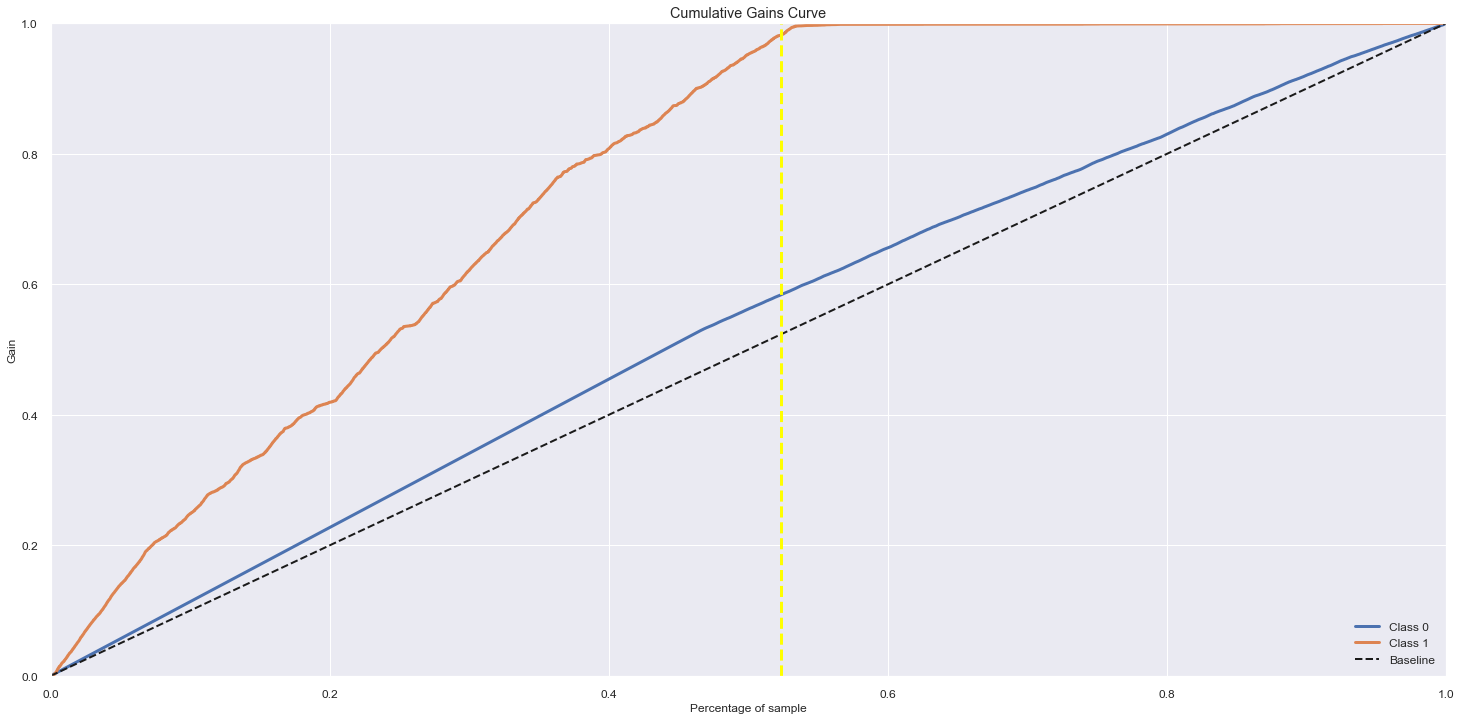

In [143]:
### Considerando 40.000 ligações para clientes: Em 52% da base, o modelo acerta em 98%, isso significa que o modelo acerta em 1.8 vezes mais que a escolha aleatória
## Considerando que são dados inéditos, o modelo está generalizando bem

percent_of_dataset = 40000 / len(data)
recall_at_40000 = recall_at_k(data, k = 40000)
precision_at_40000=precision_at_k(data,k=40000)

print('Percent of Data: ',percent_of_dataset)
print('Recall at 40000: ',recall_at_40000)
print('Precision at 40000: ',precision_at_40000)

# skplt.metrics.plot_cumulative_gain(y_test, yhat_nb)
skplt.metrics.plot_cumulative_gain(y_df_test, pred)
plt.axvline(percent_of_dataset, 0, 1, color='yellow', ls='--', lw=3)
plt.show();

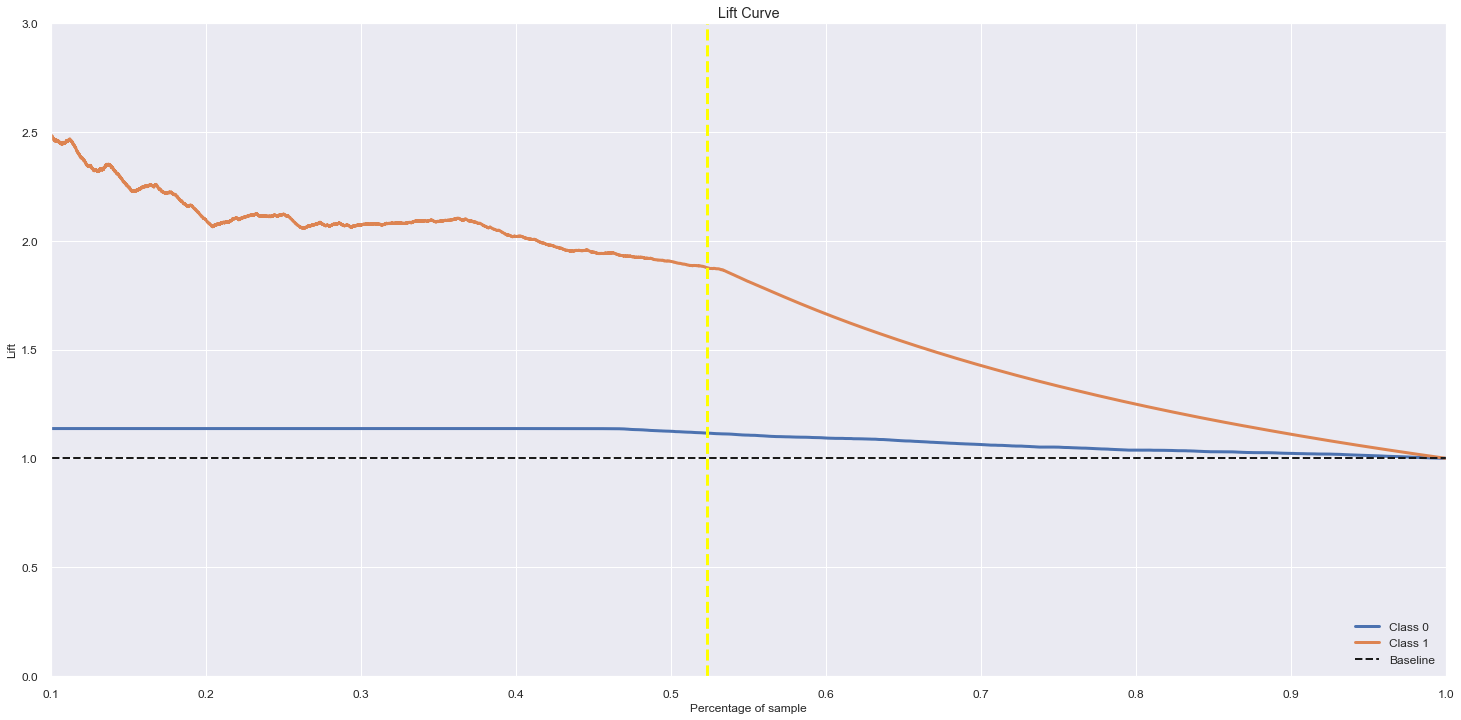

In [144]:
## A curva Lift indica a performance dos modelo de ML de classificação,
# e está indicando que o esse modelo, considerando em torno de 50% da base, acerta em 2.5x melhor que a escolha aleatória
skplt.metrics.plot_lift_curve(y_df_test, pred)
plt.axvline(percent_of_dataset, 0, 1, color='yellow', ls='--', lw=3);
plt.xlim(0.1,1);
plt.ylim(0,3);
